# Data Analysis 1 - Optimization on ArmV8

## Section 1: File Parsing

### Section 1.1: Reading Log Files

In [ ]:
import os
import pandas as pd
import seaborn as sns
import sys 
sys.path.append('/home/zhouzikai/nn_ext_dataflows/data_analysis')
from scripts import build_dataframe
import re


BASELINE_DIR = '/home/zhouzikai/nn_ext_dataflows/baselines/log'
EXTENDED_DIR = '/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log'

def parse_filename_bl(filename):
    pattern = r"([a-z]{2})_([0-9a-zA-Z]+)_baseline_(\d+)_hw_(\d+)_f_(\d+)_nf_(\d+)_s_(\d+)_(\w+)CPU__stats"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 1
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        return {
            'anchoring_stationary': match.group(1),
            'num_bits': num_bits,
            'vector_length': int(match.group(3)),
            'input_hw': int(match.group(4)),
            'filter_size': int(match.group(5)),
            'num_filters': int(match.group(6)),
            'stride': int(match.group(7)),
            'cpu_type': match.group(8),
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}
def get_file_size(file_path):
    return os.path.getsize(file_path)

def get_data_size_df_bl(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_bl(filename)
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

def append_dataframe(df1, df2, join_keyword='filename'):
    '''
    add the 'size' column from df1 to df2, assuming their indices are the same (file path)
    '''
    merged_df = df2.join(df1)

    return merged_df


def parse_filename_ex(filename):
    pattern = r"vl(\d+)_([0-9a-zA-Z]+)_stride_(\d+)_fs_(\d+)_([a-z]{2})((?:_[a-zA-Z]+_\d+)+)_hw_(\d+)_nf_(\d+)_(\w+)CPU__stats"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 1
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        # Parsing and sorting auxiliary stationary and stats pairs
        aux_pairs_str = match.group(6)
        aux_pairs = re.findall(r"_([a-zA-Z]+)_(\d+)", aux_pairs_str)
        sorted_aux_pairs = sorted(aux_pairs, key=lambda x: (x[0], int(x[1])))

        aux_data = {}
        for i, (name, value) in enumerate(sorted_aux_pairs):
            if name not in aux_data:
                aux_data[f'aux_{name}'] = int(value)
            else:
                aux_data[f'aux_{name}_{i + 1}'] = int(value)

        return {
            'vector_length': int(match.group(1)),
            'num_bits': num_bits,
            'stride': int(match.group(3)),
            'filter_size': int(match.group(4)),
            'anchoring_stationary': match.group(5),
            'input_hw': int(match.group(7)),
            'num_filters': int(match.group(8)),
            'cpu_type': match.group(9),
            **aux_data
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}
def get_file_size(file_path):
    return os.path.getsize(file_path)


def get_data_size_df_ex(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_ex(filename)
        # if (get_file_size(f)) == 0:
        #     # print("found one empty")
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

# Read Baseline Directory
df_bl = get_data_size_df_bl(BASELINE_DIR)
bl_file_list=[]
for filename in os.listdir(BASELINE_DIR):
   f = os.path.join(BASELINE_DIR, filename)
   bl_file_list.append(f)
df_bl_files = build_dataframe(bl_file_list)
df_bl= append_dataframe(df_bl,df_bl_files)

# Read Extended Directory
df_ex = get_data_size_df_ex(EXTENDED_DIR)
ex_file_list=[]
for filename in os.listdir(EXTENDED_DIR):
   f = os.path.join(EXTENDED_DIR, filename)
   ex_file_list.append(f)
df_ex_files = build_dataframe(ex_file_list)
df_ex= append_dataframe(df_ex,df_ex_files)
df_ex_ana = df_ex

In [ ]:
filename = "vl512_8bt_stride_1_fs_3_ws_os_0_is_5_hw_112_nf_8_ArmO3CPU__stats.txt"
result = parse_filename_ex(filename)
print(result)

{'vector_length': 512, 'num_bits': 8, 'stride': 1, 'filter_size': 3, 'anchoring_stationary': 'ws', 'input_hw': 112, 'num_filters': 8, 'cpu_type': 'ArmO3', 'aux_is': 5, 'aux_os': 0}


In [ ]:
df_ex

,simSeconds,simTicks,finalTick,simFreq,hostSeconds,hostTickRate,hostMemory,simInsts,simOps,hostInstRate,...,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters,cpu_type,aux_os,aux_ws,aux_is
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_2_fs_4_is_ws_0_os_5_hw_56_nf_8_ArmO3CPU__stats.txt,0.002325,2.325226e+09,2.325226e+09,1.000000e+12,34.92,66586475.0,680120.0,10047479.0,12333407.0,287723.0,...,8,2,4,is,56,8,ArmO3,5.0,0.0,NaN
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_2_fs_4_ws_os_0_is_5_hw_112_nf_8_ArmO3CPU__stats.txt,0.025362,2.536167e+10,2.635202e+10,1.000000e+12,95.37,265943072.0,680120.0,10838880.0,13076502.0,113657.0,...,8,2,4,ws,112,8,ArmO3,0.0,NaN,5.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl256_8bt_stride_2_fs_4_os_ws_5_is_8_hw_56_nf_16_ArmO3CPU__stats.txt,0.000431,4.310175e+08,1.420562e+09,1.000000e+12,8.61,50057169.0,680120.0,4062868.0,4786132.0,471834.0,...,8,2,4,os,56,16,ArmO3,NaN,5.0,8.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_1_fs_5_os_ws_5_is_0_hw_56_nf_32_ArmO3CPU__stats.txt,0.009572,9.571756e+09,1.056160e+10,1.000000e+12,188.30,50831334.0,681160.0,46744006.0,68119241.0,248236.0,...,8,1,5,os,56,32,ArmO3,NaN,5.0,0.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_2_fs_5_os_ws_0_is_5_hw_56_nf_8_ArmO3CPU__stats.txt,0.000741,7.411815e+08,1.731558e+09,1.000000e+12,12.26,60432894.0,680120.0,4353081.0,5926142.0,354917.0,...,8,2,5,os,56,8,ArmO3,NaN,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl256_8bt_stride_1_fs_5_os_ws_0_is_13_hw_56_nf_8_ArmO3CPU__stats.txt,0.001985,1.984623e+09,2.974955e+09,1.000000e+12,27.04,73402013.0,680124.0,8673812.0,10529920.0,320803.0,...,8,1,5,os,56,8,ArmO3,NaN,0.0,13.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_bin_stride_2_fs_4_is_ws_0_os_5_hw_56_nf_32_ArmO3CPU__stats.txt,0.008835,8.835468e+09,8.835468e+09,1.000000e+12,136.92,64530227.0,680124.0,43650186.0,51984738.0,318801.0,...,1,2,4,is,56,32,ArmO3,5.0,0.0,NaN
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_bin_stride_1_fs_3_is_ws_0_os_5_hw_112_nf_8_ArmO3CPU__stats.txt,0.011089,1.108915e+10,1.108915e+10,1.000000e+12,86.21,128625833.0,680116.0,20385309.0,25340871.0,236454.0,...,1,1,3,is,112,8,ArmO3,5.0,0.0,NaN
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl256_bin_stride_2_fs_3_ws_os_13_is_0_hw_56_nf_8_ArmO3CPU__stats.txt,0.000188,1.876970e+08,1.177590e+09,1.000000e+12,2.72,69063966.0,680120.0,2339384.0,2679676.0,860687.0,...,1,2,3,ws,56,8,ArmO3,13.0,NaN,0.0


In [ ]:
df_bl

,simSeconds,simTicks,finalTick,simFreq,hostSeconds,hostTickRate,hostMemory,simInsts,simOps,hostInstRate,...,system.mem_ctrls.rdPerTurnAround::896-1023,size,anchoring_stationary,num_bits,vector_length,input_hw,filter_size,num_filters,stride,cpu_type
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.056649,5.664908e+10,5.664908e+10,1.000000e+12,280.72,201802520.0,681144.0,42124919.0,42396496.0,150063.0,...,NaN,172399,ws,1,128,112,3,64,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_bin_baseline_128_hw_56_f_4_nf_16_s_1_ArmO3CPU__stats.txt,0.004103,4.103061e+09,4.103061e+09,1.000000e+12,53.96,76038771.0,681144.0,21393754.0,21665456.0,396472.0,...,NaN,172141,os,1,128,56,4,16,1,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_56_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.013981,1.398118e+10,1.398118e+10,1.000000e+12,92.45,151236364.0,681140.0,18554340.0,21032824.0,200705.0,...,NaN,172265,ws,1,512,56,3,64,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.047137,4.713684e+10,4.713684e+10,1.000000e+12,242.88,194071399.0,681140.0,37855927.0,38127504.0,155860.0,...,NaN,172137,ws,1,128,112,4,32,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_112_f_5_nf_16_s_2_ArmO3CPU__stats.txt,0.014157,1.415693e+10,1.415693e+10,1.000000e+12,147.49,95987469.0,681144.0,43321281.0,55780535.0,293729.0,...,NaN,171877,os,8,512,112,5,16,2,ArmO3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/is_bin_baseline_128_hw_56_f_3_nf_64_s_1_ArmO3CPU__stats.txt,0.025114,2.511420e+10,2.511420e+10,1.000000e+12,173.58,144682786.0,681144.0,50598563.0,50870169.0,291498.0,...,NaN,172394,is,1,128,56,3,64,1,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_128_hw_56_f_3_nf_16_s_2_ArmO3CPU__stats.txt,0.001389,1.388558e+09,1.388558e+09,1.000000e+12,15.11,91923314.0,680116.0,4460928.0,4732103.0,295313.0,...,NaN,171734,os,8,128,56,3,16,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.057760,5.776026e+10,5.776026e+10,1.000000e+12,331.96,174000023.0,681144.0,61456501.0,69615596.0,185135.0,...,NaN,172013,ws,1,512,112,4,32,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_56_f_4_nf_8_s_2_ArmO3CPU__stats.txt,0.001794,1.793547e+09,1.793547e+09,1.000000e+12,19.46,92150946.0,681144.0,5166835.0,6405958.0,265466.0,...,NaN,171874,os,8,512,56,4,8,2,ArmO3


In [ ]:
len(df_bl)

864

In [ ]:
len(df_ex)

1568

### Section 2.2: Filtering to Useful Columns Only

In [ ]:
COL_FILTER = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters"]

REF_COLS = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters","system.cpu.dcache.demandMissRate::cpu.data","system.cpu.dcache.demandAvgMissLatency::total","system.cpu.dcache.writebacks::total","system.mem_ctrls.dram.numReads::cpu.data","system.mem_ctrls.dram.numWrites::total"]

df_bl = df_bl[COL_FILTER]
df_ex = df_ex[COL_FILTER]

In [ ]:
df_ex = df_ex.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"]).min()

In [ ]:
df_bl

,simSeconds,simInsts,simOps,vector_length,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.056649,42124919.0,42396496.0,128,1,2,3,ws,112,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_bin_baseline_128_hw_56_f_4_nf_16_s_1_ArmO3CPU__stats.txt,0.004103,21393754.0,21665456.0,128,1,1,4,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_56_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.013981,18554340.0,21032824.0,512,1,2,3,ws,56,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.047137,37855927.0,38127504.0,128,1,2,4,ws,112,32
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_112_f_5_nf_16_s_2_ArmO3CPU__stats.txt,0.014157,43321281.0,55780535.0,512,8,2,5,os,112,16
...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/is_bin_baseline_128_hw_56_f_3_nf_64_s_1_ArmO3CPU__stats.txt,0.025114,50598563.0,50870169.0,128,1,1,3,is,56,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_128_hw_56_f_3_nf_16_s_2_ArmO3CPU__stats.txt,0.001389,4460928.0,4732103.0,128,8,2,3,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.057760,61456501.0,69615596.0,512,1,2,4,ws,112,32
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_56_f_4_nf_8_s_2_ArmO3CPU__stats.txt,0.001794,5166835.0,6405958.0,512,8,2,4,os,56,8


In [ ]:
df_ex

simSeconds   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       8           is                      0.001307  \
                                                               os                      0.000466   
                                                               ws                      0.000568   
                                                   16          is                      0.002829   
                                                               os                      0.001733   
...                                                                                         ...   
512           8        2      5           112      32          os                      0.022314   
                                                               ws                      0.158446   
                                                   64          is                      0.092795   
                                                               os                      0.045203   
                                                               ws                      0.318287   

                                                                                        simInsts   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary                
128           1        1      3           56       8           is                      3506831.0  \
                                                               os                      3762228.0   
                                                               ws                      3312574.0   
                                                   16          is                      5356424.0   
                                                               os                      5867205.0   
...                                                                                          ...   
512           8        2      5           112      32          os                     45633182.0   
                                                               ws                     59023862.0   
                                                   64          is                    468653867.0   
                                                               os                     89609046.0   
                                                               ws                    116390414.0   

                                                                                          simOps  
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       8           is                      3775992.0  
                                                               os                      4031382.0  
                                                               ws                      3704840.0  
                                                   16          is                      5625665.0  
                                                               os                      6136431.0  
...                                                                                          ...  
512           8        2      5           112      32          os                     67455024.0  
                                                               ws                     71616056.0  
                                                   64          is                    570270848.0  
                                                               os                    132983593.0  
                                                               ws                    141305649.0  

[864 rows x 3 columns]

### Section 2.3: Merging baseline and optimized dataframes

In [ ]:
df_ex = df_ex.rename(columns={"simSeconds":"simSeconds_opt","simInsts":"simInsts_opt","simOps":"simOps_opt"})
df_merged = pd.merge(df_ex,df_bl,how='left',\
                    left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"],\
                    right_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"])

In [ ]:
NUM_FILTER_LOWER = 32
NUM_FILTER_UPPER = 64
VEC_LEN_LIST = [128,256,512]

In [ ]:
df_merged

,vector_length,num_bits,stride,filter_size,input_hw,num_filters,anchoring_stationary,simSeconds_opt,simInsts_opt,simOps_opt,simSeconds,simInsts,simOps
0,128,1,1,3,56,8,is,0.001307,3506831.0,3775992.0,0.002728,7786158.0,8057764.0
1,128,1,1,3,56,8,os,0.000466,3762228.0,4031382.0,0.001901,7649254.0,7920915.0
2,128,1,1,3,56,8,ws,0.000568,3312574.0,3704840.0,0.002117,6695706.0,6967312.0
3,128,1,1,3,56,16,is,0.002829,5356424.0,5625665.0,0.006385,13902231.0,14173837.0
4,128,1,1,3,56,16,os,0.001733,5867205.0,6136431.0,0.003189,13628103.0,13899772.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,512,8,2,5,112,32,os,0.022314,45633182.0,67455024.0,0.027347,84974677.0,109622091.0
860,512,8,2,5,112,32,ws,0.158446,59023862.0,71616056.0,0.084633,82078547.0,94541802.0
861,512,8,2,5,112,64,is,0.092795,468653867.0,570270848.0,0.162161,258580346.0,263308149.0
862,512,8,2,5,112,64,os,0.045203,89609046.0,132983593.0,0.053818,168281642.0,217305409.0


In [ ]:
df_merged = df_merged[(df_merged["num_filters"]>= NUM_FILTER_LOWER) &(df_merged["num_filters"]<= NUM_FILTER_UPPER)& (df_merged["vector_length"].isin(VEC_LEN_LIST)) & (df_merged["stride"]==1)]

<Axes: xlabel='simSeconds'>

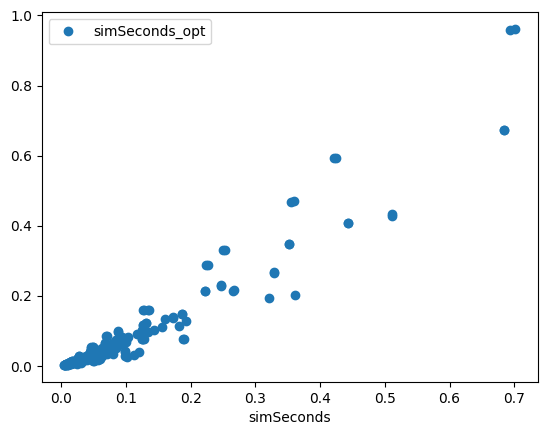

In [ ]:
df_merged.plot(x="simSeconds",y="simSeconds_opt",style=['o','rx'])

## Section 2: Calculating Improvments

In [ ]:
df_merged["improvement"] = df_merged["simSeconds"]/df_merged["simSeconds_opt"]

/tmp/ipykernel_267266/1120125696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["improvement"] = df_merged["simSeconds"]/df_merged["simSeconds_opt"]


(array([ 0.,  0.,  4., 20., 40., 52., 47., 13., 10., 13.,  2.,  6.,  2.,
         4.,  2.,  1.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

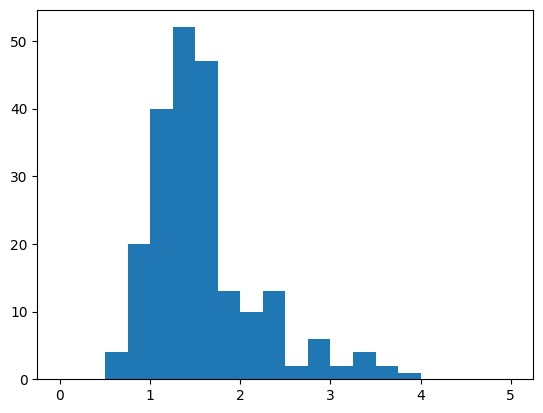

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df_merged['improvement'], range=[0, 5],bins=20)

(array([ 0.,  0.,  0.,  0.,  0., 19., 20.,  1.,  6.,  9.,  2.,  6.,  2.,
         4.,  2.,  1.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

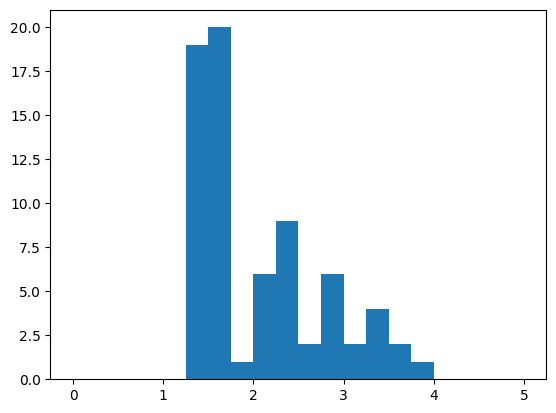

In [ ]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='is']['improvement'], range=[0, 5],bins=20)

(array([ 0.,  0.,  0.,  0.,  9., 28., 19.,  8.,  4.,  4.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

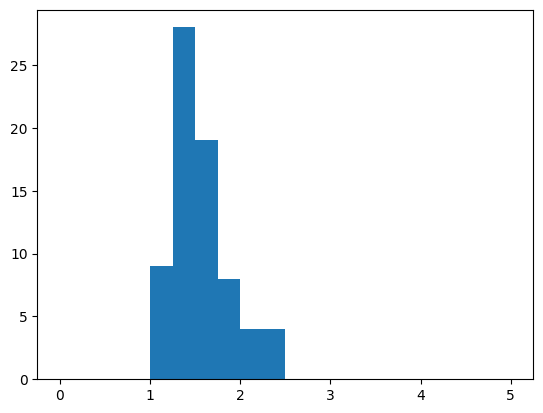

In [ ]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='os']['improvement'], range=[0, 5],bins=20)

(array([ 0.,  0.,  4., 20., 31.,  5.,  8.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

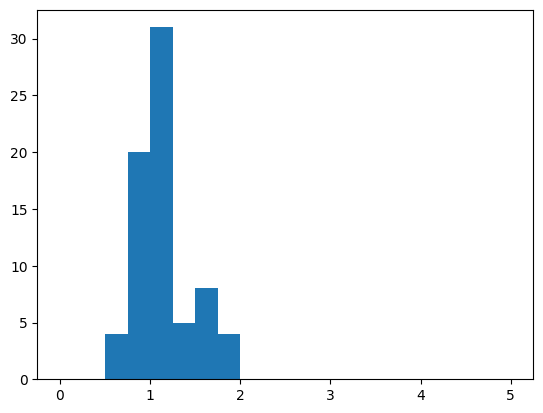

In [ ]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='ws']['improvement'], range=[0, 5],bins=20)

In [ ]:
df_merged['improvement'].mean()

1.5869795760418162

In [ ]:
df_merged['improvement'].median()

1.4532486069327373

In [ ]:
len(df_merged["vector_length"]==128)

216

In [ ]:
len(df_merged["vector_length"]==256)

216

In [ ]:
len(df_merged["vector_length"]==512)

216

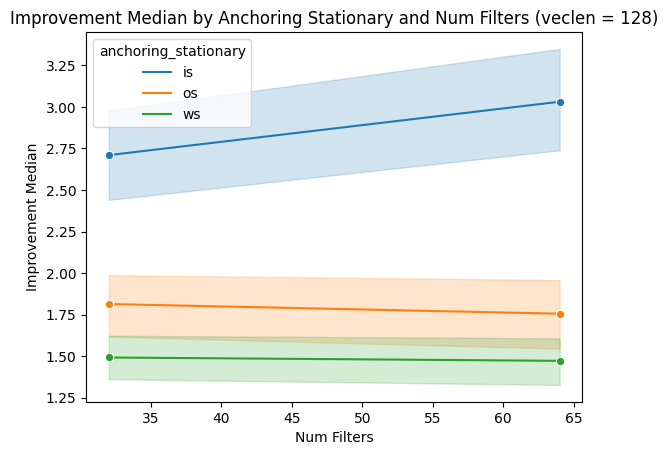

In [ ]:
grouped_df = df_merged.groupby(["anchoring_stationary","num_filters","vector_length","num_bits","input_hw","simSeconds_opt","filter_size"])["improvement"].median().reset_index()
sns.lineplot(data=grouped_df[(grouped_df["vector_length"]==128)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 128)'
)
plt.show()

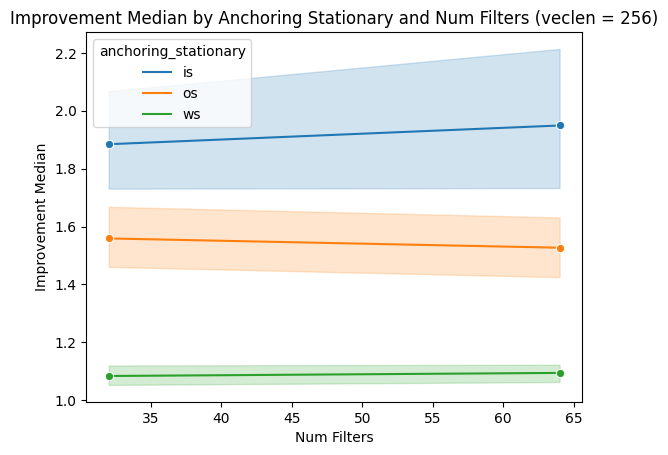

In [ ]:
sns.lineplot(data=grouped_df[grouped_df["vector_length"]==256], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 256)'
)
plt.show()

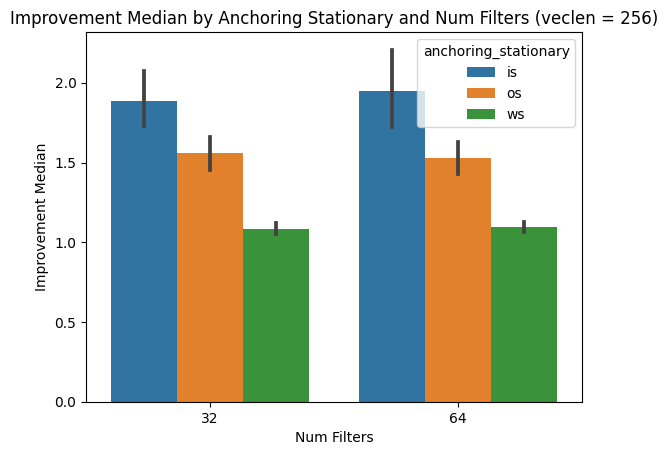

In [ ]:
sns.barplot(data=grouped_df[grouped_df["vector_length"]==256], x='num_filters', y='improvement', hue='anchoring_stationary')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 256)')
plt.show()


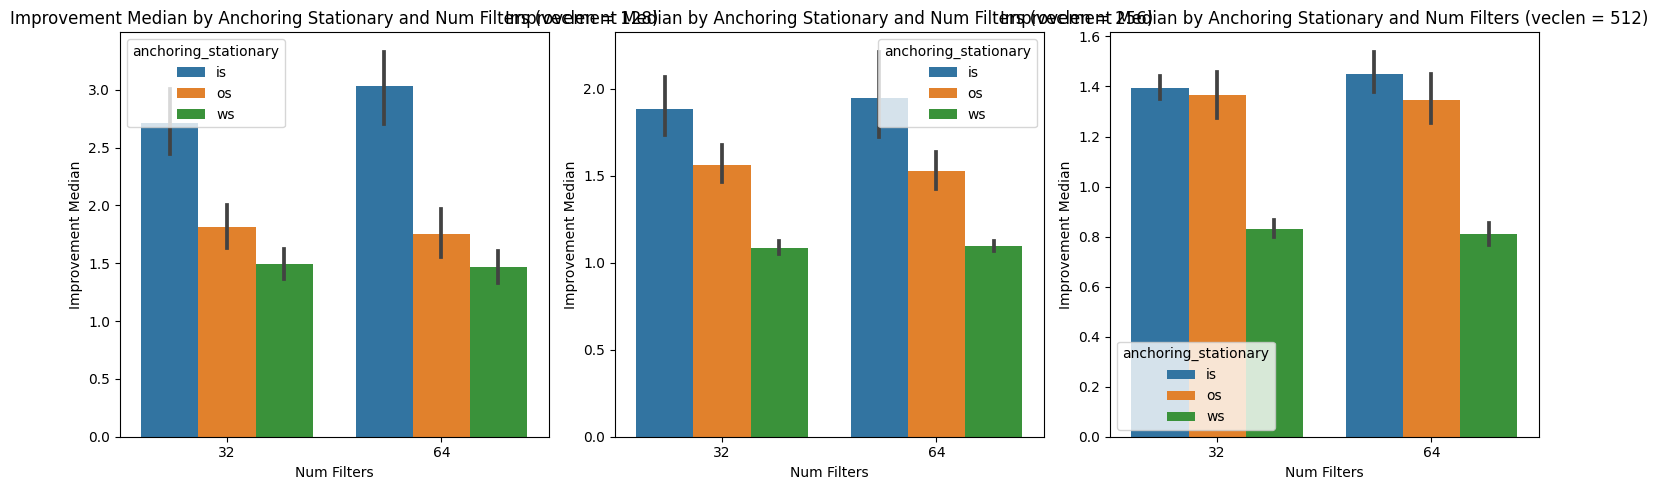

In [ ]:
import matplotlib.pyplot as plt

vector_lengths = [128, 256, 512]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with three subplots

for i, vector_length in enumerate(vector_lengths):
    data_subset = grouped_df[grouped_df["vector_length"] == vector_length]  # Subset the data based on vector_length
    
    ax = axes[i]  # Select the current subplot
    sns.barplot(data=data_subset, x='num_filters', y='improvement', hue='anchoring_stationary', ax=ax)
    ax.set_xlabel('Num Filters')
    ax.set_ylabel('Improvement Median')
    ax.set_title(f'Improvement Median by Anchoring Stationary and Num Filters (veclen = {vector_length})')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


/tmp/ipykernel_267266/2606954227.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


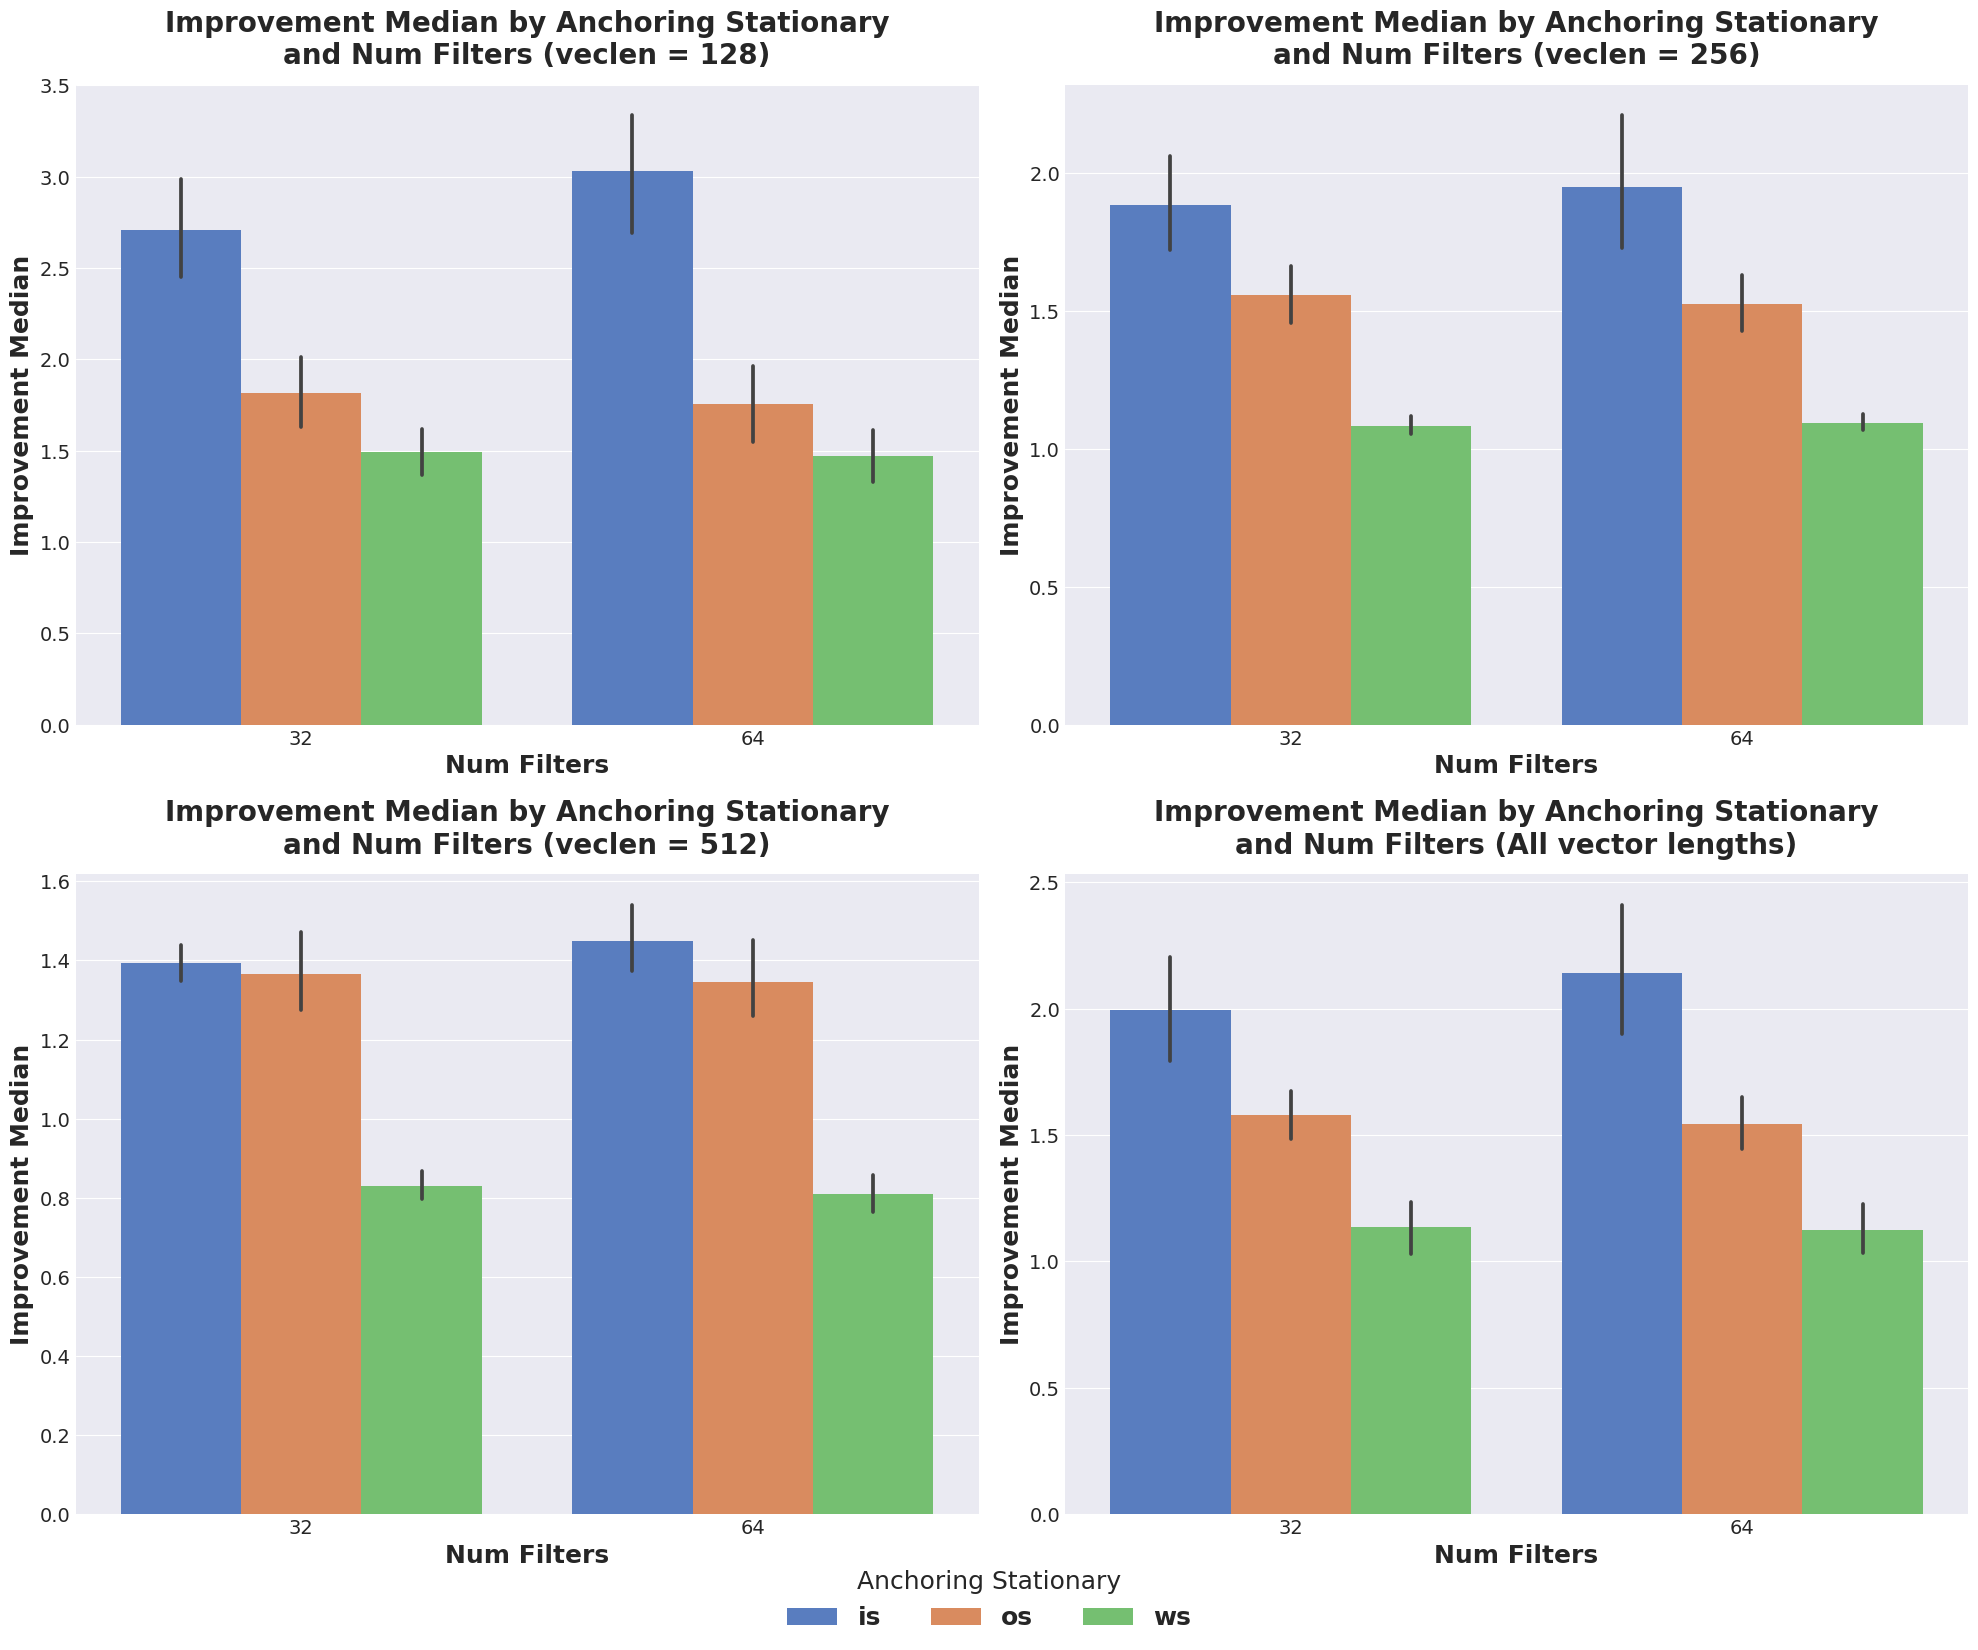

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a plotting style to make it look more academic
plt.style.use('seaborn-darkgrid')

# Increase the font size
plt.rcParams.update({'font.size': 14})

# Set the color palette to "muted"
sns.set_palette("muted")

vector_lengths = [128, 256, 512]

fig, axes = plt.subplots(2, 2, figsize=(20, 16))  # Create a figure with four subplots arranged in a 2x2 grid, and make it taller
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, vector_length in enumerate(vector_lengths):
    data_subset = grouped_df[grouped_df["vector_length"] == vector_length]  # Subset the data based on vector_length
    
    ax = axes[i]  # Select the current subplot
    sns.barplot(data=data_subset, x='num_filters', y='improvement', hue='anchoring_stationary', ax=ax)
    ax.set_xlabel('Num Filters', fontsize=18, fontweight='bold')
    ax.set_ylabel('Improvement Median', fontsize=18, fontweight='bold')
    ax.set_title(f'Improvement Median by Anchoring Stationary\nand Num Filters (veclen = {vector_length})', fontsize=20, pad=15, fontweight='bold')
    ax.get_legend().remove()

# Add a holistic plot for all vector lengths
ax = axes[-1]
sns.barplot(data=grouped_df, x='num_filters', y='improvement', hue='anchoring_stationary', ax=ax)
ax.set_xlabel('Num Filters', fontsize=18, fontweight='bold')
ax.set_ylabel('Improvement Median', fontsize=18, fontweight='bold')
ax.set_title('Improvement Median by Anchoring Stationary\nand Num Filters (All vector lengths)', fontsize=20, pad=15, fontweight='bold')

# Remove legend from the last subplot
ax.get_legend().remove()

# Add legend below the entire figure
handles, labels = ax.get_legend_handles_labels()
legend = fig.legend(handles, labels, title='Anchoring Stationary', loc='lower center', bbox_to_anchor=(0.5, -0.04), ncol=3, fontsize='18', title_fontsize='18')
plt.setp(legend.get_texts(), fontweight='bold')  # Set legend text to bold

plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust spacing between subplots and leave less space at the bottom for legend
plt.savefig("images/improvement_medians.png", dpi=300, bbox_inches='tight')  # Save the figure with the legend included
plt.show()


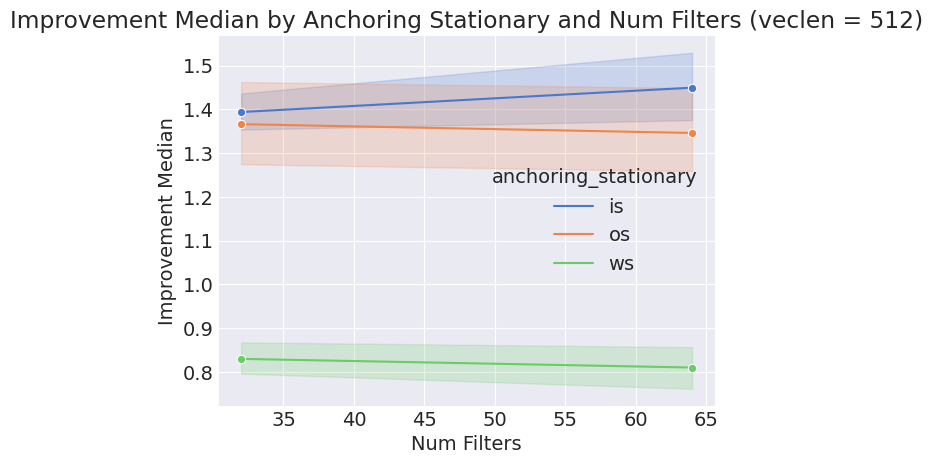

In [ ]:
sns.lineplot(data=grouped_df[grouped_df["vector_length"]==512], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 512)'
)
plt.show()

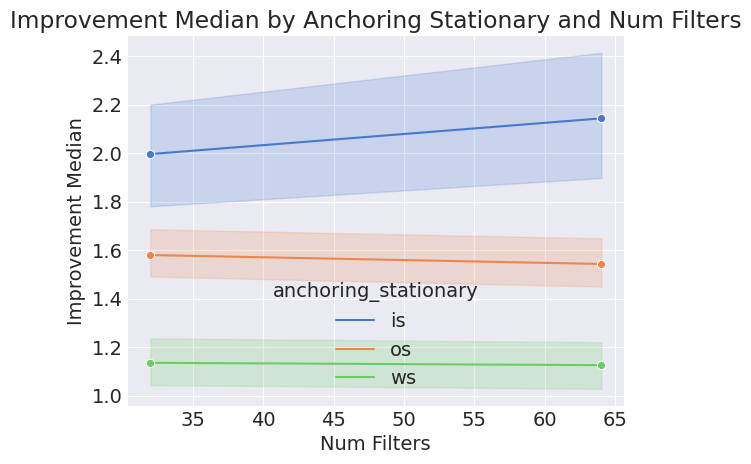

In [ ]:
sns.lineplot(data=grouped_df, x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters'
)
plt.show()

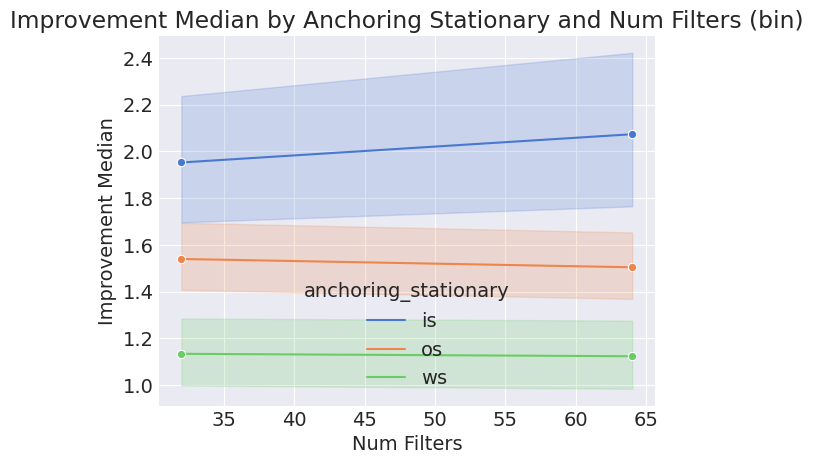

In [ ]:

sns.lineplot(data=grouped_df[grouped_df["num_bits"]==1], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (bin)'
)
plt.show()

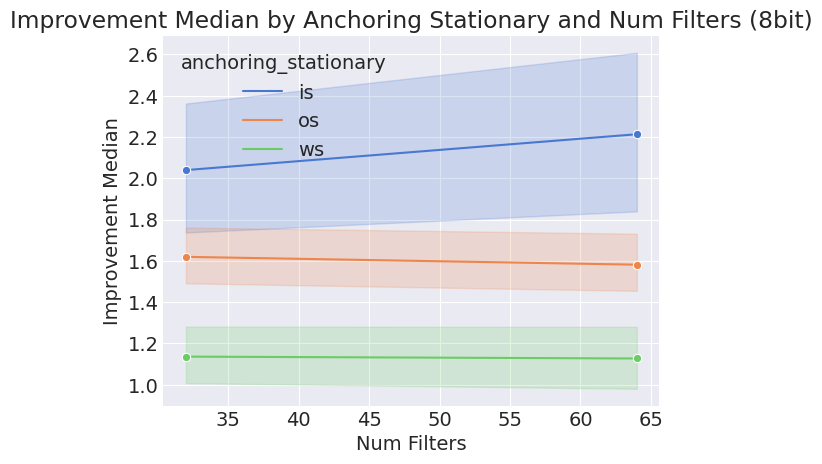

In [ ]:
sns.lineplot(data=grouped_df[grouped_df["num_bits"]==8], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (8bit)'
)
plt.show()

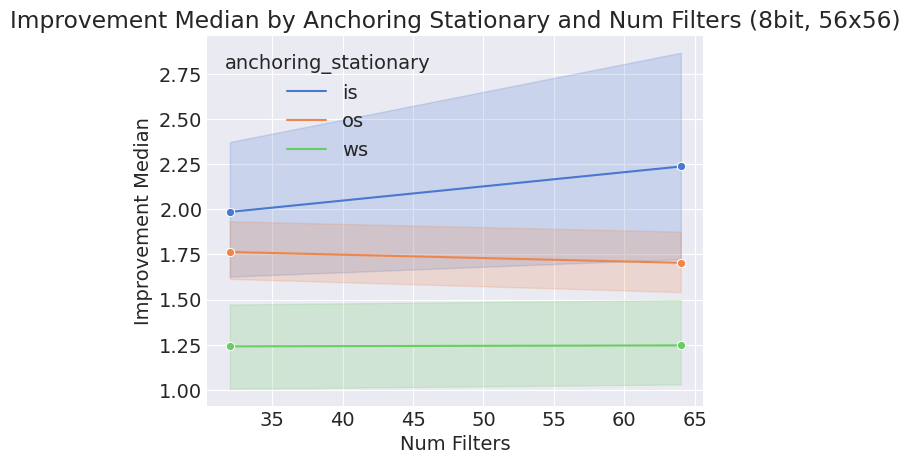

In [ ]:

sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==8) & (grouped_df["input_hw"]==56)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (8bit, 56x56)'
)
plt.show()

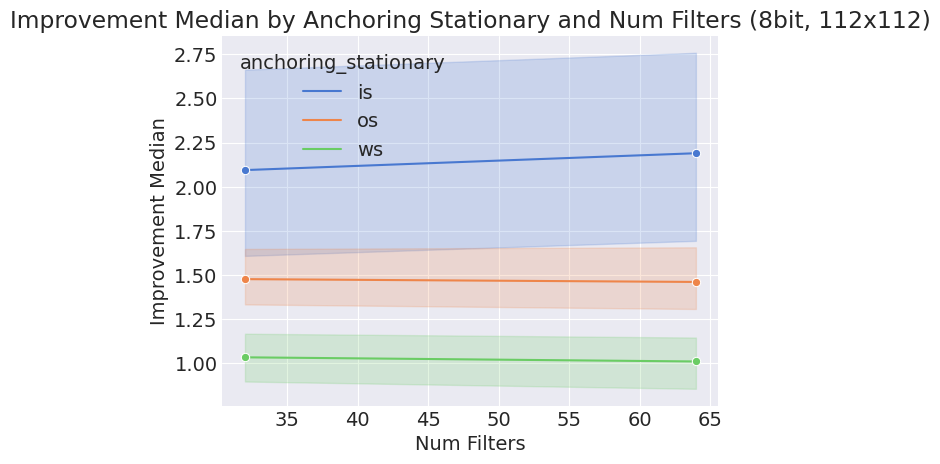

In [ ]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==8) & (grouped_df["input_hw"]==112)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (8bit, 112x112)'
)
plt.show()

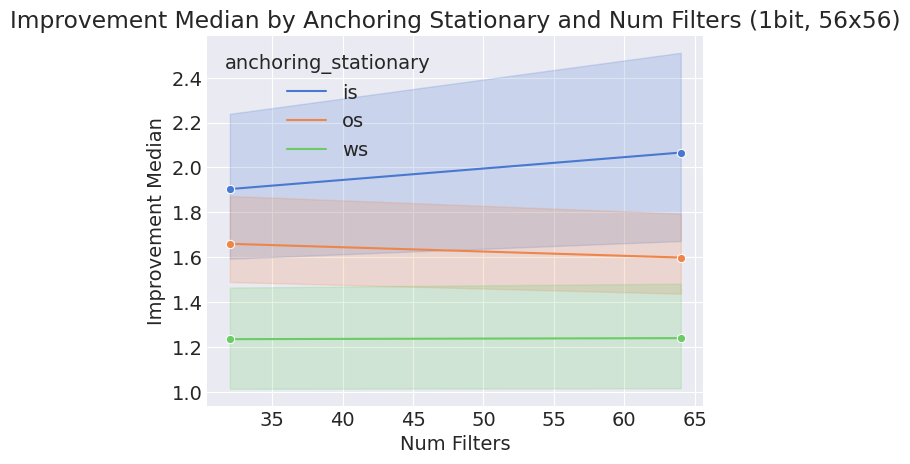

In [ ]:

sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==1) & (grouped_df["input_hw"]==56)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (1bit, 56x56)'
)
plt.show()

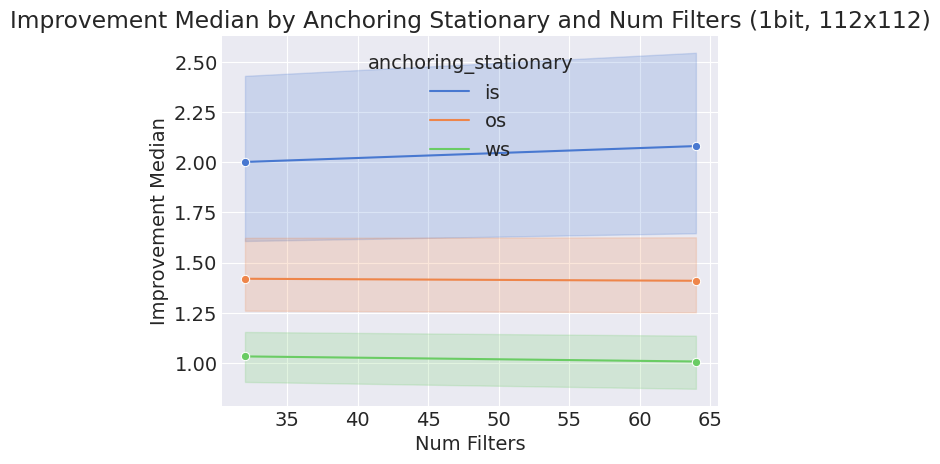

In [ ]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==1) & (grouped_df["input_hw"]==112)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (1bit, 112x112)'
)
plt.show()

/tmp/ipykernel_267266/2427416667.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
/tmp/ipykernel_267266/2427416667.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=grouped_df, x='num_filters', y='improvement', hue='anchoring_stationary', marker='o', linewidth=5.0, ci=None)


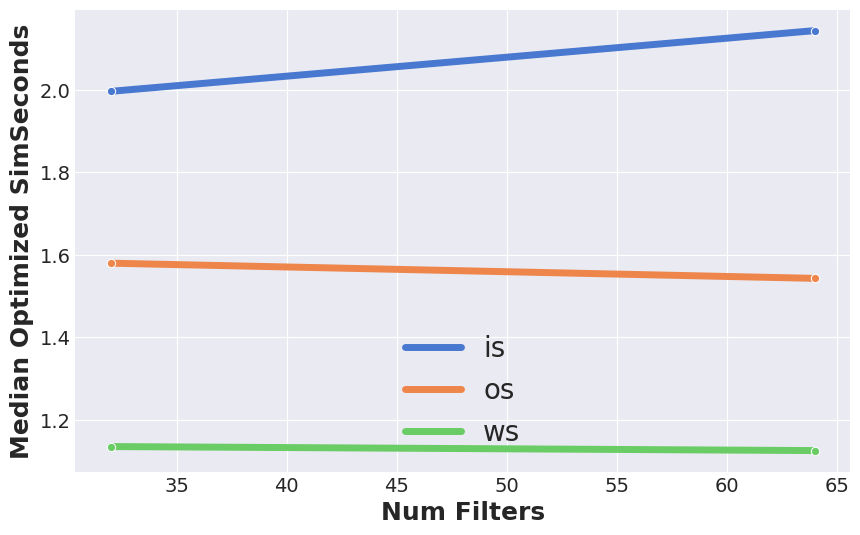

In [ ]:
# Set a plotting style to make it look more academic
plt.figure(figsize=(10,6))
plt.style.use('seaborn-darkgrid')

# Increase the font size
plt.rcParams.update({'font.size': 14})

# Create the lineplot without the range (confidence interval) and with increased line width (e.g., 2.0)
ax = sns.lineplot(data=grouped_df, x='num_filters', y='improvement', hue='anchoring_stationary', marker='o', linewidth=5.0, ci=None)

# Add labels and title with specified font size and weight
plt.xlabel('Num Filters', fontsize="18", weight="bold")
plt.ylabel('Median Optimized SimSeconds', fontsize="18", weight="bold")

# Get the legend
legend = ax.legend(fontsize="20")

# Modify the lines in the legend to be thicker
for line in legend.get_lines():
    line.set_linewidth(5.0)

# Save the figure
plt.savefig("images/opt_dfs_8bit.png")

# Display the plot
plt.show()

In [ ]:
grouped_df = df_merged.groupby(["anchoring_stationary","num_filters","vector_length","num_bits","input_hw","simSeconds_opt","filter_size"])["improvement"].mean().reset_index()

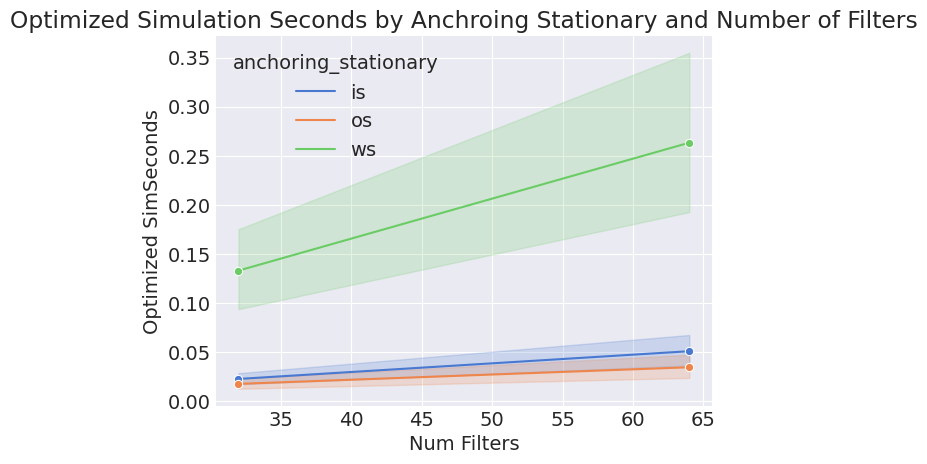

In [ ]:
sns.lineplot(data=grouped_df, x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters'
)
plt.show()

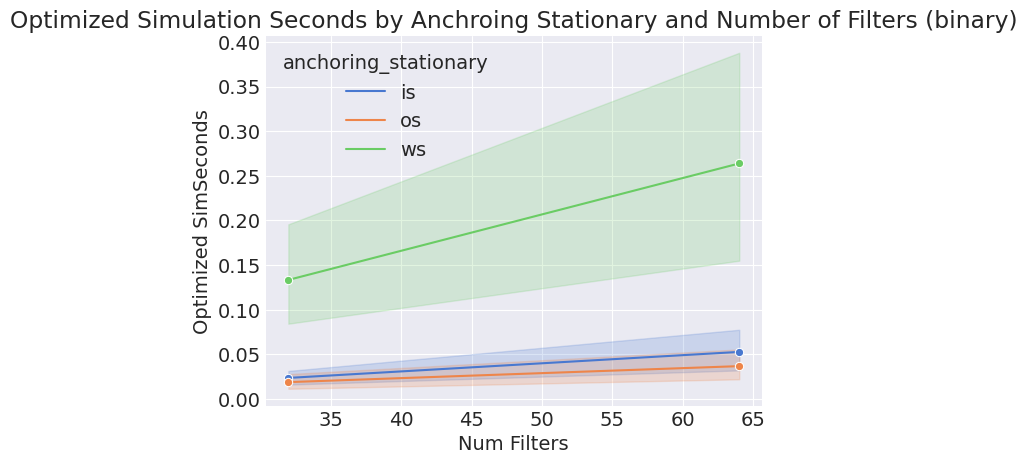

In [ ]:
sns.lineplot(data=grouped_df[grouped_df["num_bits"]==1], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (binary)'
)
plt.show()

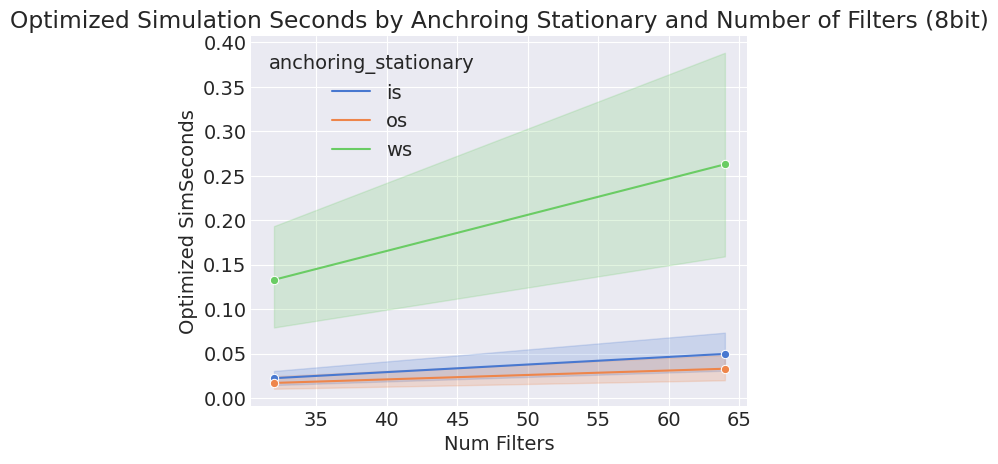

In [ ]:
sns.lineplot(data=grouped_df[grouped_df["num_bits"]==8], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (8bit)'
)
plt.show()

/tmp/ipykernel_267266/2573803475.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
/tmp/ipykernel_267266/2573803475.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=grouped_df[grouped_df["num_bits"]==8], x='num_filters', y='simSeconds_opt',


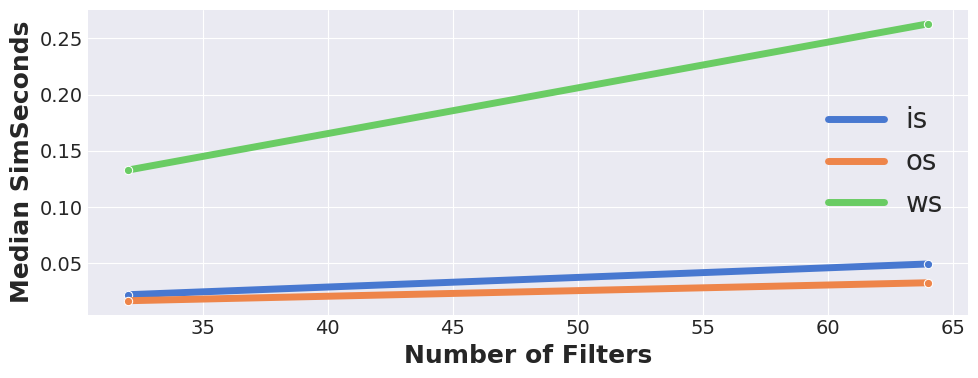

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set a plotting style to make it look more academic
plt.style.use('seaborn-darkgrid')

# Set up the figure size
plt.figure(figsize=(10,4))

# Increase the default font size
plt.rcParams.update({'font.size': 14})

# Generate the lineplot without the range (confidence interval) and with increased line width
# The data is filtered to include only rows where "num_bits" equals 8
ax = sns.lineplot(data=grouped_df[grouped_df["num_bits"]==8], x='num_filters', y='simSeconds_opt', 
                  hue='anchoring_stationary', marker='o', linewidth=5.0, ci=None)

# Add labels and title with specified font size and weight
plt.xlabel('Number of Filters', fontsize=18, weight="bold")
plt.ylabel('Median SimSeconds', fontsize=18, weight="bold")

# Get the current legend from the plot
legend = ax.legend(fontsize=20)

# Modify the lines in the legend to be thicker
for line in legend.get_lines():
    line.set_linewidth(5.0)

# Add padding to ensure the full figure is saved
plt.tight_layout()

# Save the figure in the specified directory
plt.savefig("images/opt_dfs_8bit.png")

# Display the plot
plt.show()


/tmp/ipykernel_267266/2434116449.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
/tmp/ipykernel_267266/2434116449.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=grouped_df[grouped_df["num_bits"]==1], x='num_filters', y='simSeconds_opt',


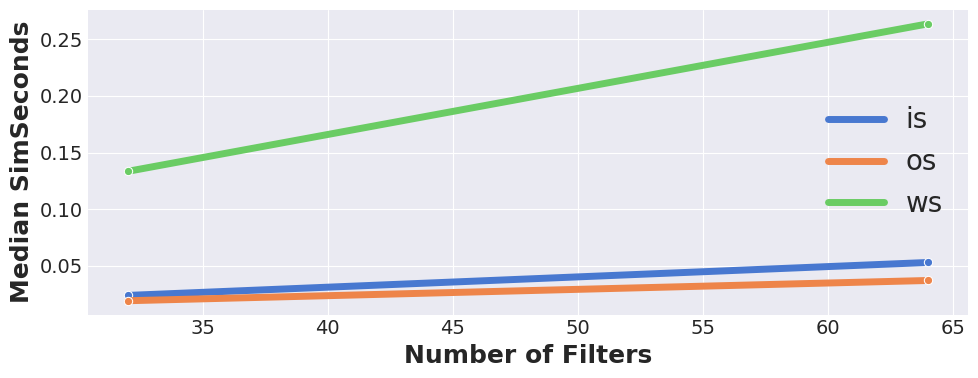

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set a plotting style to make it look more academic
plt.style.use('seaborn-darkgrid')

# Set up the figure size
plt.figure(figsize=(10,4))

# Increase the default font size
plt.rcParams.update({'font.size': 14})

# Generate the lineplot without the range (confidence interval) and with increased line width
# The data is filtered to include only rows where "num_bits" equals 1
ax = sns.lineplot(data=grouped_df[grouped_df["num_bits"]==1], x='num_filters', y='simSeconds_opt', 
                  hue='anchoring_stationary', marker='o', linewidth=5.0, ci=None)

# Add labels and title with specified font size and weight
plt.xlabel('Number of Filters', fontsize=18, weight="bold")
plt.ylabel('Median SimSeconds', fontsize=18, weight="bold")

# Get the current legend from the plot
legend = ax.legend(fontsize=20)

# Modify the lines in the legend to be thicker
for line in legend.get_lines():
    line.set_linewidth(5.0)

# Add padding to ensure the full figure is saved
plt.tight_layout()

# Save the figure in the specified directory
plt.savefig("images/opt_dfs_bin.png")

# Display the plot
plt.show()


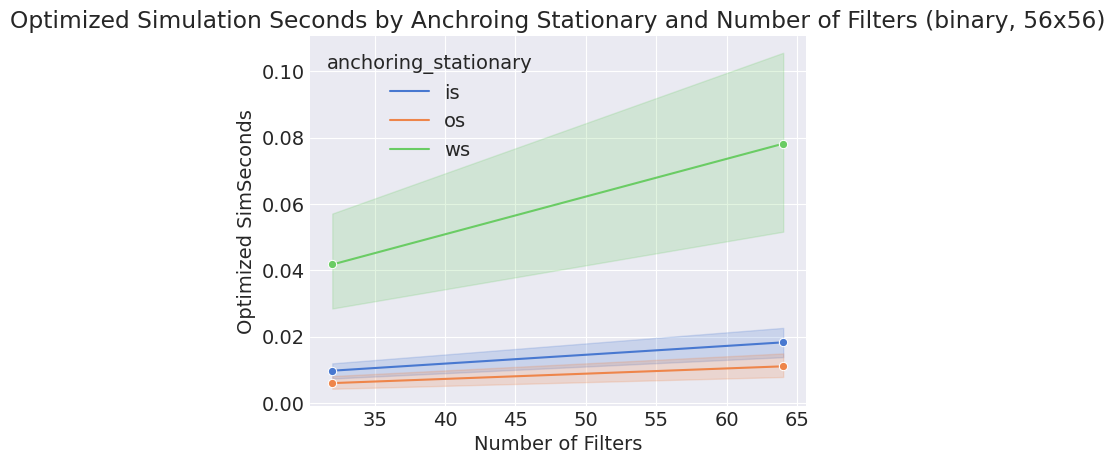

In [ ]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==1)&(grouped_df["input_hw"]==56)], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Number of Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (binary, 56x56)'
)
plt.show()

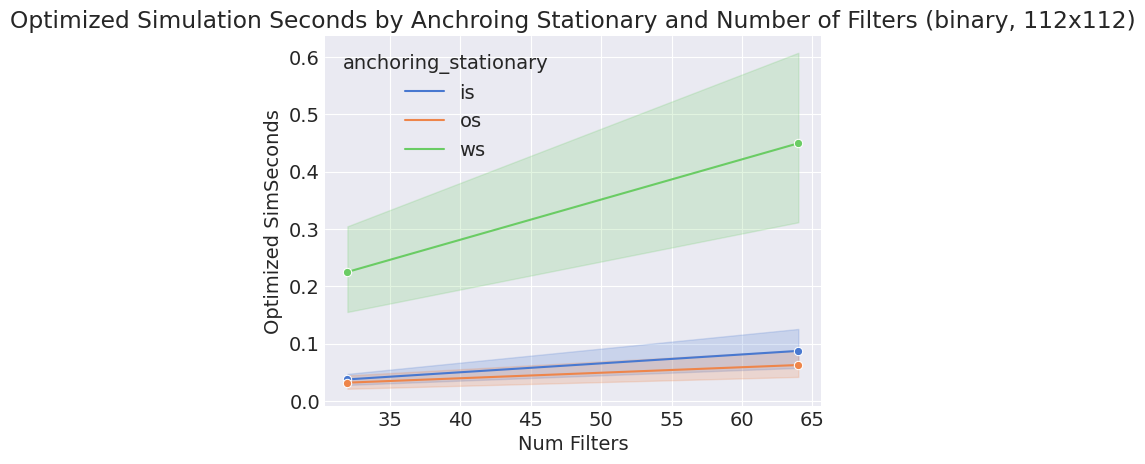

In [ ]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==1)&(grouped_df["input_hw"]==112)], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (binary, 112x112)'
)
plt.show()

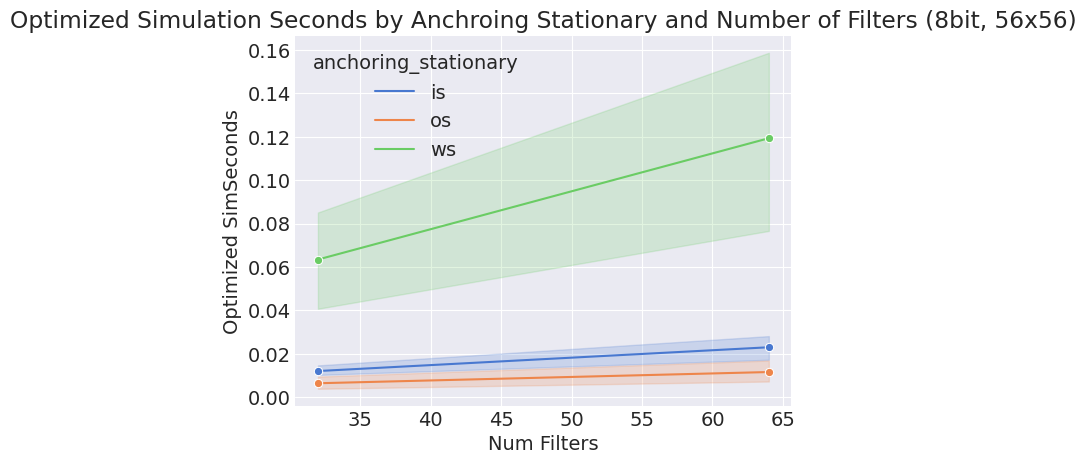

In [ ]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==8)&(grouped_df["input_hw"]==56)&(grouped_df["filter_size"]==5)], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (8bit, 56x56)'
)
plt.show()

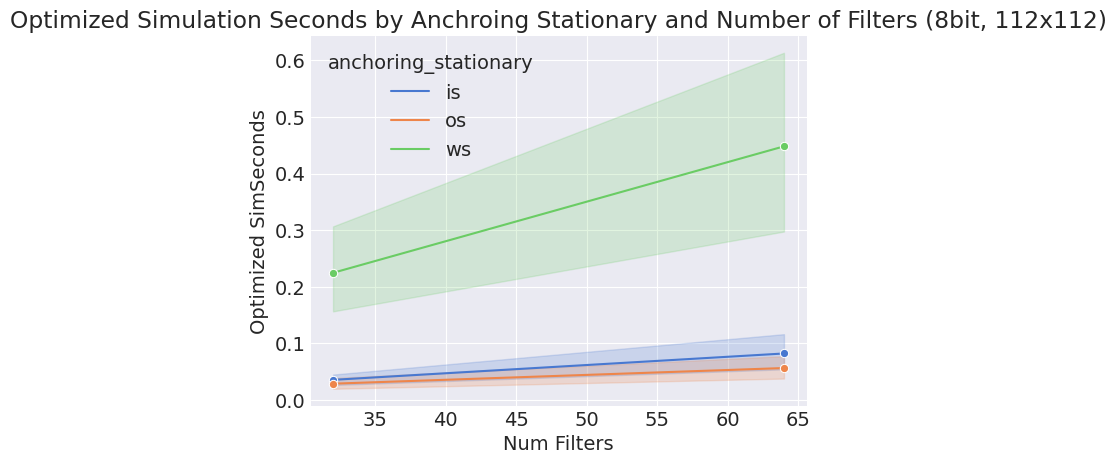

In [ ]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==8)&(grouped_df["input_hw"]==112)], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (8bit, 112x112)'
)
plt.show()

In [ ]:
grouped_df

,anchoring_stationary,num_filters,vector_length,num_bits,input_hw,simSeconds_opt,filter_size,improvement
0,is,32,128,1,56,0.004423,3,2.658377
1,is,32,128,1,56,0.005751,4,2.648409
2,is,32,128,1,56,0.009312,5,2.219609
3,is,32,128,1,112,0.015432,3,3.204705
4,is,32,128,1,112,0.020965,4,2.894586
...,...,...,...,...,...,...,...,...
211,ws,64,512,8,56,0.098185,4,0.889525
212,ws,64,512,8,56,0.158733,5,0.847095
213,ws,64,512,8,112,0.330580,3,0.756455
214,ws,64,512,8,112,0.593523,4,0.709096


In [ ]:
def calculate_is_ws_difference(group):
    ws_value = group.loc[group['anchoring_stationary'] == 'ws', 'simSeconds_opt'].min()
    is_value = group.loc[group['anchoring_stationary'] == 'is', 'simSeconds_opt'].min()
    return (ws_value - is_value) / is_value

def calculate_os_ws_difference(group):
    ws_value = group.loc[group['anchoring_stationary'] == 'ws', 'simSeconds_opt'].min()
    os_value = group.loc[group['anchoring_stationary'] == 'os', 'simSeconds_opt'].min()
    return (ws_value - os_value) / os_value


def calculate_is_os_difference(group):
    is_value = group.loc[group['anchoring_stationary'] == 'is', 'simSeconds_opt'].min()
    os_value = group.loc[group['anchoring_stationary'] == 'os', 'simSeconds_opt'].min()
    return (is_value - os_value) / os_value

In [ ]:
is_ws_diff = df_merged.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters']).apply(calculate_is_ws_difference).reset_index(name='is_ws_difference')

os_ws_diff = df_merged.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters']).apply(calculate_os_ws_difference).reset_index(name='os_ws_difference')

is_os_diff = df_merged.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters']).apply(calculate_is_os_difference).reset_index(name='is_os_difference')

<Axes: >

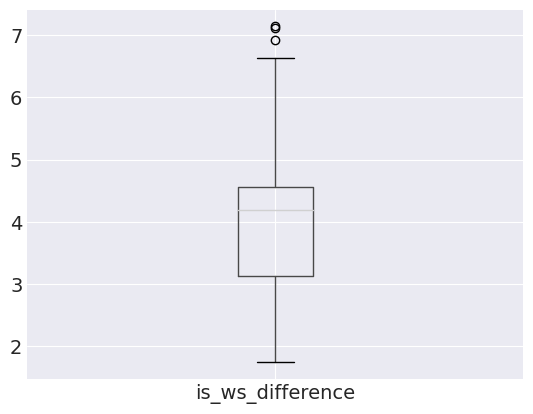

In [ ]:
is_ws_diff.boxplot(column="is_ws_difference")

<Axes: >

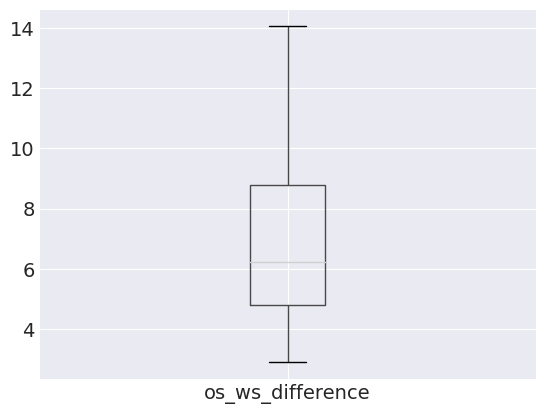

In [ ]:
os_ws_diff.boxplot(column="os_ws_difference")

<Axes: >

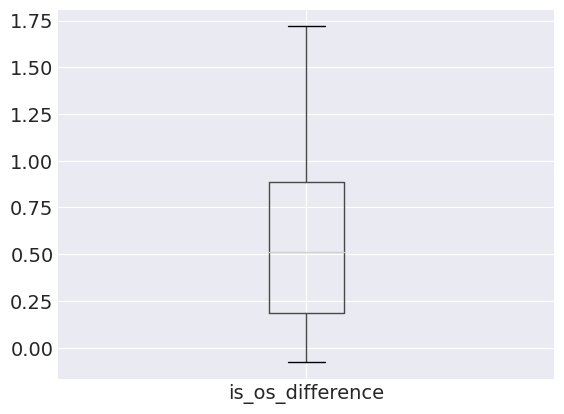

In [ ]:
is_os_diff.boxplot(column="is_os_difference")

In [ ]:
len(is_os_diff[is_os_diff["is_os_difference"]<=0])/len(is_os_diff[is_os_diff["is_os_difference"].notna()])

0.06944444444444445

### Analyzing Baselines

In [ ]:
df_bl_is = df_bl[df_bl["anchoring_stationary"]=="is"]
df_bl_os = df_bl[df_bl["anchoring_stationary"]=="os"]
df_bl_ws = df_bl[df_bl["anchoring_stationary"]=="ws"]

In [ ]:
df_bl_is = df_bl_is.rename(columns={"simSeconds":"simSeconds_is","simInsts":"simInsts_is","simOps":"simOps_is"})
df_bl_os = df_bl_os.rename(columns={"simSeconds":"simSeconds_os","simInsts":"simInsts_os","simOps":"simOps_os"})
df_bl_ws = df_bl_ws.rename(columns={"simSeconds":"simSeconds_ws","simInsts":"simInsts_ws","simOps":"simOps_ws"})

In [ ]:
df_bl_db = pd.merge(df_bl_is,df_bl_os,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])
df_bl_db

,simSeconds_is,simInsts_is,simOps_is,vector_length,num_bits,stride,filter_size,anchoring_stationary_x,input_hw,num_filters,simSeconds_os,simInsts_os,simOps_os,anchoring_stationary_y
0,0.021003,33753483.0,34269763.0,256,8,2,5,is,56,32,0.003716,17734332.0,20372914.0,os
1,0.008192,15191466.0,15680024.0,256,1,2,3,is,56,32,0.002488,8803833.0,9957343.0,os
2,0.004804,13702812.0,14784495.0,256,1,1,4,is,56,8,0.003328,13433136.0,15225598.0,os
3,0.025354,59709872.0,63867203.0,256,1,1,3,is,56,64,0.010226,58213276.0,65454626.0,os
4,0.064387,197878337.0,211455543.0,256,1,1,4,is,112,32,0.037942,189695501.0,214973782.0,os
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.002820,5045534.0,5371609.0,256,8,2,3,is,56,8,0.001280,3284963.0,3776576.0,os
284,0.022904,51120183.0,51391760.0,128,1,1,3,is,112,16,0.009900,49167118.0,49438791.0,os
285,0.188082,310741427.0,311012522.0,128,8,1,5,is,112,64,0.060581,432072062.0,432343156.0,os
286,0.032718,99773118.0,106697268.0,256,1,1,4,is,112,16,0.019546,95683002.0,108457971.0,os


In [ ]:
df_bl_tp = pd.merge(df_bl_db,df_bl_ws,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])
df_bl_tp

,simSeconds_is,simInsts_is,simOps_is,vector_length,num_bits,stride,filter_size,anchoring_stationary_x,input_hw,num_filters,simSeconds_os,simInsts_os,simOps_os,anchoring_stationary_y,simSeconds_ws,simInsts_ws,simOps_ws,anchoring_stationary
0,0.021003,33753483.0,34269763.0,256,8,2,5,is,56,32,0.003716,17734332.0,20372914.0,os,0.006335,17080178.0,18536617.0,ws
1,0.008192,15191466.0,15680024.0,256,1,2,3,is,56,32,0.002488,8803833.0,9957343.0,os,0.004044,7907847.0,8620925.0,ws
2,0.004804,13702812.0,14784495.0,256,1,1,4,is,56,8,0.003328,13433136.0,15225598.0,os,0.011012,12472358.0,13504604.0,ws
3,0.025354,59709872.0,63867203.0,256,1,1,3,is,56,64,0.010226,58213276.0,65454626.0,os,0.048583,50525610.0,54283168.0,ws
4,0.064387,197878337.0,211455543.0,256,1,1,4,is,112,32,0.037942,189695501.0,214973782.0,os,0.222222,174777531.0,187553428.0,ws
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.002820,5045534.0,5371609.0,256,8,2,3,is,56,8,0.001280,3284963.0,3776576.0,os,0.001410,3062121.0,3443655.0,ws
284,0.022904,51120183.0,51391760.0,128,1,1,3,is,112,16,0.009900,49167118.0,49438791.0,os,0.053352,41638683.0,41910260.0,ws
285,0.188082,310741427.0,311012522.0,128,8,1,5,is,112,64,0.060581,432072062.0,432343156.0,os,0.510858,406092468.0,406363565.0,ws
286,0.032718,99773118.0,106697268.0,256,1,1,4,is,112,16,0.019546,95683002.0,108457971.0,os,0.111791,88223768.0,94747505.0,ws


In [ ]:
df_bl_tp["is_over_os"] = df_bl_tp["simSeconds_is"] / df_bl_tp["simSeconds_os"]
df_bl_tp["ws_over_os"] = df_bl_tp["simSeconds_ws"] / df_bl_tp["simSeconds_os"]

In [ ]:
grouped_tmp = df_bl_tp[["simSeconds_is","simSeconds_os","simSeconds_ws","num_filters","stride"]].groupby(["num_filters","stride"]).median().reset_index()
grouped = grouped_tmp[grouped_tmp["stride"]==1]
grouped_s2 = grouped_tmp[grouped_tmp["stride"]==2]

/tmp/ipykernel_267266/3331024072.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


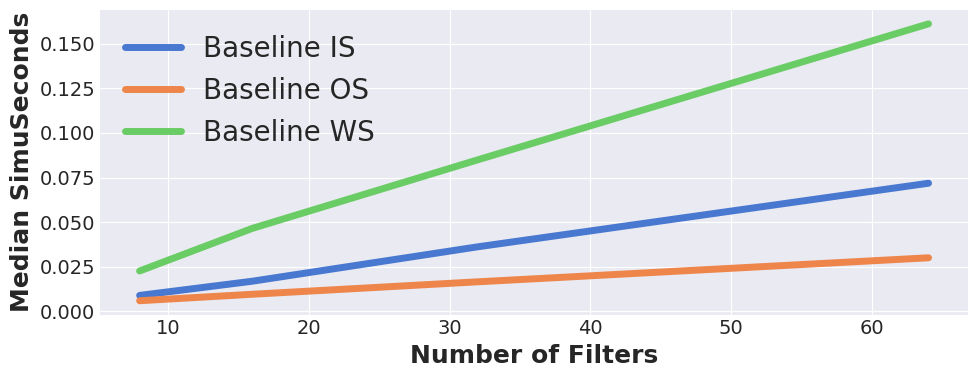

In [ ]:
# Set a plotting style to make it look more academic
plt.figure(figsize=(10,4))
plt.style.use('seaborn-darkgrid')

# Increase the font size
plt.rcParams.update({'font.size': 14})

# Plot the lines with increased line width (e.g., 2.0)
plt.plot(grouped["num_filters"], grouped['simSeconds_is'], label='Baseline IS', linewidth=5.0)
plt.plot(grouped["num_filters"], grouped['simSeconds_os'], label='Baseline OS', linewidth=5.0)
plt.plot(grouped["num_filters"], grouped['simSeconds_ws'], label='Baseline WS', linewidth=5.0)

# Add labels, legend, and title
plt.xlabel('Number of Filters',fontsize="18",weight="bold")
plt.ylabel('Median SimuSeconds',fontsize="18",weight="bold")
plt.legend(fontsize="20")
plt.tight_layout()
plt.savefig("images/bl_sim_dfs_s1.png")
# Display the plot
plt.show()

/tmp/ipykernel_267266/2877969895.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


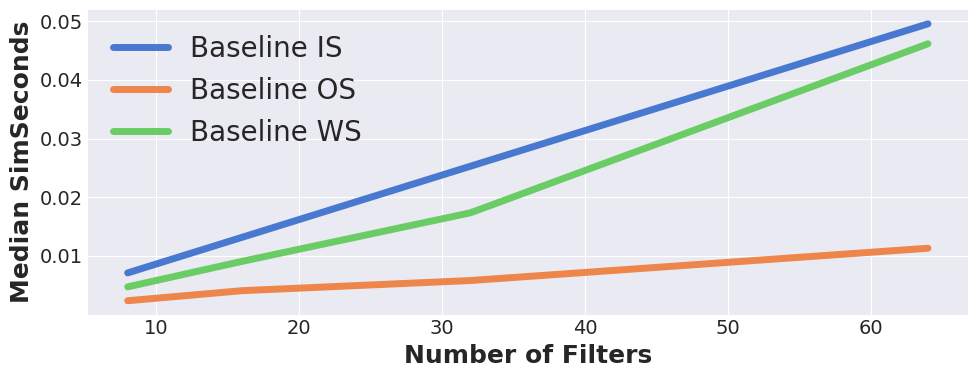

In [ ]:
# Set a plotting style to make it look more academic
plt.figure(figsize=(10,4))
plt.style.use('seaborn-darkgrid')

# Increase the font size
plt.rcParams.update({'font.size': 14})

# Plot the lines with increased line width (e.g., 2.0)
plt.plot(grouped_s2["num_filters"], grouped_s2['simSeconds_is'], label='Baseline IS', linewidth=5.0)
plt.plot(grouped_s2["num_filters"], grouped_s2['simSeconds_os'], label='Baseline OS', linewidth=5.0)
plt.plot(grouped_s2["num_filters"], grouped_s2['simSeconds_ws'], label='Baseline WS', linewidth=5.0)

# Add labels, legend, and title
plt.xlabel('Number of Filters',fontsize="18",weight="bold")
plt.ylabel('Median SimSeconds',fontsize="18",weight="bold")
plt.legend(fontsize="20")
plt.tight_layout()
plt.savefig("images/bl_sim_dfs_s2.png")
# Display the plot
plt.show()

<Axes: >

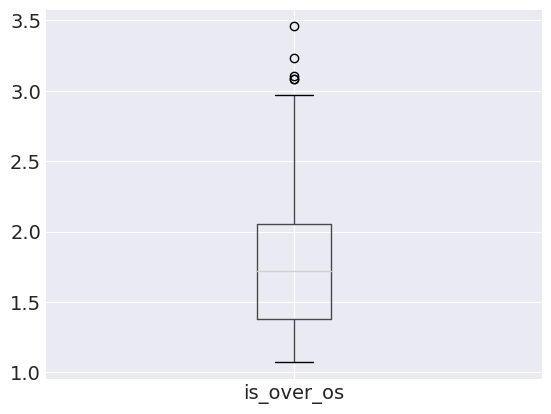

In [ ]:
df_bl_tp[df_bl_tp["stride"]==1].boxplot(column="is_over_os")

In [ ]:
df_bl_tp[df_bl_tp["stride"]==1]["is_over_os"].median()

1.7190344717283477

In [ ]:
df_bl_tp[df_bl_tp["stride"]==2]["is_over_os"].median()

3.415347269710426

In [ ]:
df_bl_tp[df_bl_tp["stride"]==1]["ws_over_os"].median()

4.581050268735383

In [ ]:
df_bl_tp[df_bl_tp["stride"]==2]["ws_over_os"].median()

2.630388501508683

<Axes: >

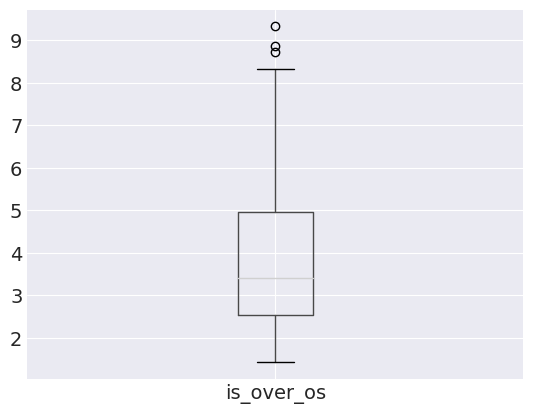

In [ ]:
df_bl_tp[df_bl_tp["stride"]==2].boxplot(column="is_over_os")

In [ ]:
len(df_bl_tp[df_bl_tp["is_over_os"]>=1])/len(df_bl_tp)

1.0

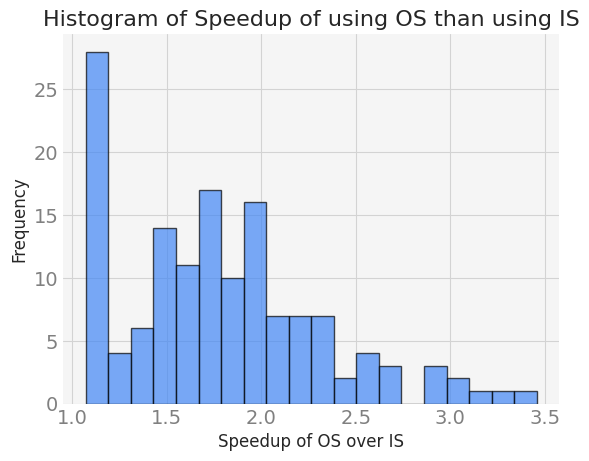

In [ ]:

# Set the plot style
sns.set_style("whitegrid")

# Filter the DataFrame
filtered_df = df_bl_tp[df_bl_tp["stride"] == 1]

# Define color and marker options
hist_color = "#4287f5"  # Blue color
marker = "o"  # Circle marker

# Plot the histogram
plt.hist(filtered_df["is_over_os"], bins=20, color=hist_color, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel("Speedup of OS over IS", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Histogram of Speedup of using OS than using IS", fontsize=16)

# Customize grid and tick colors
plt.grid(color='lightgray')
plt.tick_params(colors='gray')

# Add a background color
plt.gca().set_facecolor('#f5f5f5')

plt.savefig("images/os_over_is_bl.png", dpi=300)
# Show the plot
plt.show()

In [ ]:
df_bl_tp["ws_over_os"] = df_bl_tp["simSeconds_ws"] / df_bl_tp["simSeconds_os"]

In [ ]:
df_bl_tp["ws_over_is"] = df_bl_tp["simSeconds_ws"] / df_bl_tp["simSeconds_is"]

<Axes: >

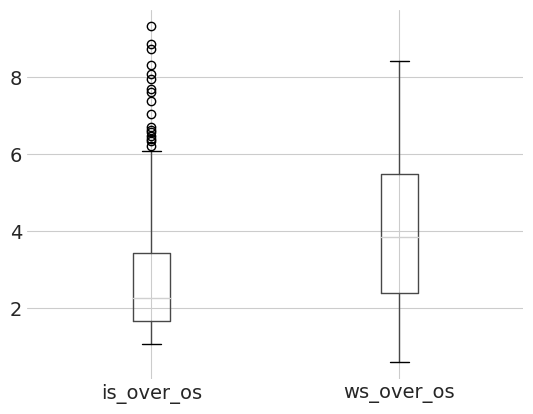

In [ ]:
df_bl_tp.boxplot(column=["is_over_os","ws_over_os"])

In [ ]:
df_bl_tp["ws_over_os"].median()

3.835969145434657

<Axes: >

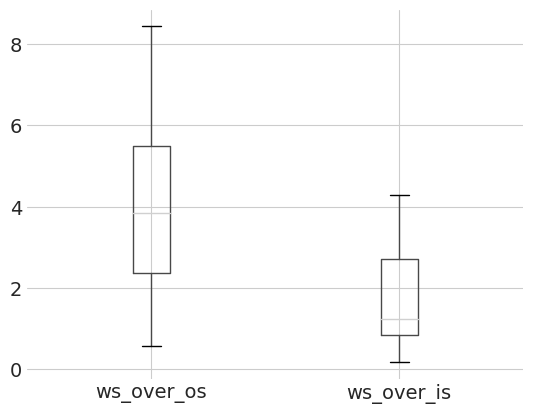

In [ ]:
df_bl_tp.boxplot(column=["ws_over_os","ws_over_is"])

In [ ]:
len(df_bl_tp[df_bl_tp["ws_over_os"]>=1])/len(df_bl_tp)

0.96875

In [ ]:
len(df_bl_tp[df_bl_tp["ws_over_is"]>=1])/len(df_bl_tp)

0.6458333333333334

In [ ]:
df_ex

simSeconds_opt   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary                   
128           1        1      3           56       8           is                          0.001307  \
                                                               os                          0.000466   
                                                               ws                          0.000568   
                                                   16          is                          0.002829   
                                                               os                          0.001733   
...                                                                                             ...   
512           8        2      5           112      32          os                          0.022314   
                                                               ws                          0.158446   
                                                   64          is                          0.092795   
                                                               os                          0.045203   
                                                               ws                          0.318287   

                                                                                     simInsts_opt   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary                 
128           1        1      3           56       8           is                       3506831.0  \
                                                               os                       3762228.0   
                                                               ws                       3312574.0   
                                                   16          is                       5356424.0   
                                                               os                       5867205.0   
...                                                                                           ...   
512           8        2      5           112      32          os                      45633182.0   
                                                               ws                      59023862.0   
                                                   64          is                     468653867.0   
                                                               os                      89609046.0   
                                                               ws                     116390414.0   

                                                                                      simOps_opt  
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       8           is                      3775992.0  
                                                               os                      4031382.0  
                                                               ws                      3704840.0  
                                                   16          is                      5625665.0  
                                                               os                      6136431.0  
...                                                                                          ...  
512           8        2      5           112      32          os                     67455024.0  
                                                               ws                     71616056.0  
                                                   64          is                    570270848.0  
                                                               os                    132983593.0  
                                                               ws                    141305649.0  

[864 rows x 3 columns]

### Auxiliary Analysis

In [ ]:
is_anchored = df_ex_ana[(df_ex_ana["anchoring_stationary"]=="is") & (df_ex_ana["stride"] == 1)]
os_anchored = df_ex_ana[(df_ex_ana["anchoring_stationary"]=="os")& (df_ex_ana["stride"] == 1)]
ws_anchored = df_ex_ana[(df_ex_ana["anchoring_stationary"]=="ws")& (df_ex_ana["stride"] == 1)]

In [ ]:
is_anchored["prefer_ws"] = (is_anchored["aux_ws"] == is_anchored["filter_size"] * is_anchored["filter_size"]) | ((is_anchored["aux_os"] == 0) & (is_anchored["aux_ws"] > 0))

is_anchored["prefer_os"] =(is_anchored["aux_os"] == is_anchored["filter_size"] * (is_anchored["filter_size"] - is_anchored["stride"])) | ((is_anchored["aux_os"] > 0) & (is_anchored["aux_ws"] == 0))

os_anchored["prefer_ws"] = (os_anchored["aux_ws"] == os_anchored["filter_size"] * os_anchored["filter_size"])  | ((os_anchored["aux_is"] == 0) & (os_anchored["aux_ws"] > 0))

os_anchored["prefer_is"] = (os_anchored["aux_is"] != os_anchored["filter_size"] * (os_anchored["filter_size"] - os_anchored["stride"])) | ((os_anchored["aux_is"] > 0) & (os_anchored["aux_ws"] == 0))

ws_anchored["prefer_is"] = ws_anchored["aux_os"] == 0
ws_anchored["prefer_os"] = ws_anchored["aux_is"] == 0

/tmp/ipykernel_267266/1436946333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_anchored["prefer_ws"] = (is_anchored["aux_ws"] == is_anchored["filter_size"] * is_anchored["filter_size"]) | ((is_anchored["aux_os"] == 0) & (is_anchored["aux_ws"] > 0))
/tmp/ipykernel_267266/1436946333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_anchored["prefer_os"] =(is_anchored["aux_os"] == is_anchored["filter_size"] * (is_anchored["filter_size"] - is_anchored["stride"])) | ((is_anchored["aux_os"] > 0) & (

In [ ]:
df_is_aux = pd.merge(is_anchored[is_anchored["prefer_ws"]].rename(columns={"simSeconds":"simSeconds_pws"}),is_anchored[is_anchored["prefer_os"]].rename(columns={"simSeconds":"simSeconds_pos"}),how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

df_os_aux = pd.merge(os_anchored[os_anchored["prefer_is"]].rename(columns={"simSeconds":"simSeconds_pis"}),os_anchored[os_anchored["prefer_ws"]].rename(columns={"simSeconds":"simSeconds_pws"}),how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

df_ws_aux = pd.merge(ws_anchored[ws_anchored["prefer_is"]].rename(columns={"simSeconds":"simSeconds_pis"}),ws_anchored[ws_anchored["prefer_os"]].rename(columns={"simSeconds":"simSeconds_pos"}),how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

In [ ]:
df_is_aux["ws_faster"]= (df_is_aux["simSeconds_pws"] - df_is_aux["simSeconds_pos"]) < 0
df_os_aux["ws_faster"]= (df_os_aux["simSeconds_pws"] - df_os_aux["simSeconds_pis"]) < 0
df_ws_aux["os_faster"]= (df_ws_aux["simSeconds_pos"] - df_ws_aux["simSeconds_pis"]) < 0
df_ws_aux["is_faster"]= (df_ws_aux["simSeconds_pos"] - df_ws_aux["simSeconds_pis"]) > 0

In [ ]:
len(df_ws_aux[df_ws_aux["os_faster"]])/len(df_ws_aux[df_ws_aux["is_faster"]])

3.3636363636363638

In [ ]:
len(df_is_aux[df_is_aux["ws_faster"]]) / (len(df_is_aux[df_is_aux["ws_faster"]])+ len(df_is_aux[df_is_aux["ws_faster"]==False]))

0.3611111111111111

In [ ]:
df_is_aux["os_faster"]= (df_is_aux["simSeconds_pos"] - df_is_aux["simSeconds_pws"]) < 0
df_is_aux["os_ws_same"] = (df_is_aux["simSeconds_pws"] == df_is_aux["simSeconds_pos"])
df_os_aux["is_os_same"] = (df_os_aux["simSeconds_pws"]==df_os_aux["simSeconds_pis"])
df_os_aux["is_faster"]= (df_os_aux["simSeconds_pis"] - df_os_aux["simSeconds_pws"]) < 0

In [ ]:
len(df_is_aux[df_is_aux["os_faster"]]) / (len(df_is_aux[df_is_aux["os_faster"]])+ len((df_is_aux[(df_is_aux["os_faster"]==False)&(df_is_aux["os_ws_same"]==False)]) ))

0.5315315315315315

In [ ]:
len(df_is_aux[df_is_aux["ws_faster"]]) / (len(df_is_aux[df_is_aux["ws_faster"]])+ len((df_is_aux[(df_is_aux["ws_faster"]==False)&(df_is_aux["os_ws_same"]==False)]) ))

0.46846846846846846

In [ ]:
len(df_ws_aux[df_ws_aux["os_faster"]]) / (len(df_ws_aux[df_ws_aux["os_faster"]])+ len(df_ws_aux[df_ws_aux["os_faster"]==False]))

0.7708333333333334

In [ ]:
df_is_aux["ws_faster_mag"]= (df_is_aux["simSeconds_pws"] - df_is_aux["simSeconds_pos"])/df_is_aux["simSeconds_pws"]
df_os_aux["ws_faster_mag"]= (df_os_aux["simSeconds_pws"] - df_os_aux["simSeconds_pis"])/df_os_aux["simSeconds_pws"]
df_ws_aux["os_faster_mag"]= (df_ws_aux["simSeconds_pis"] - df_ws_aux["simSeconds_pos"])/df_ws_aux["simSeconds_pis"]

<Axes: >

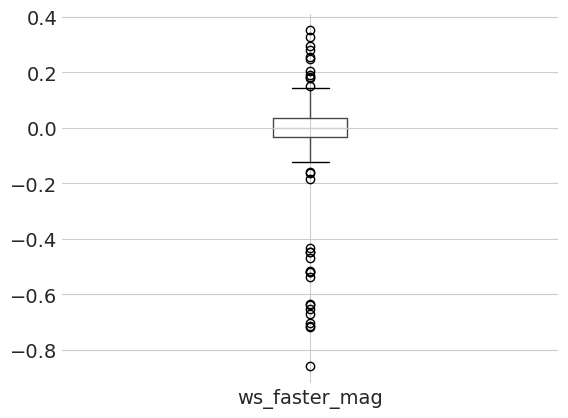

In [ ]:
df_is_aux.boxplot(column="ws_faster_mag")

In [ ]:
df_is_aux["os_faster"]

0      False
1       True
2       True
3      False
4      False
       ...  
139     True
140     True
141    False
142    False
143    False
Name: os_faster, Length: 144, dtype: bool

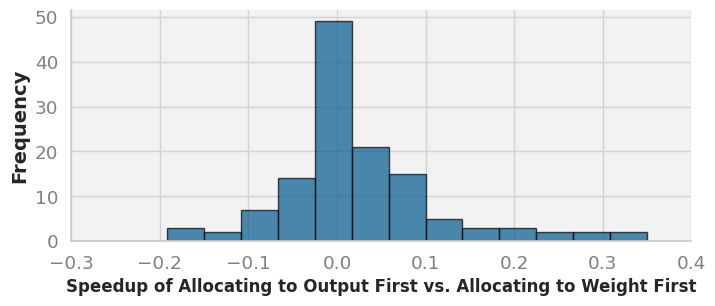

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a formal style using Seaborn
sns.set(style="whitegrid", font_scale=1.2)

# Plot the histogram
plt.figure(figsize=(8, 3))  # Adjust the figure size if needed
plt.hist(df_is_aux["ws_faster_mag"], bins=29, color='#005a8d', edgecolor='black', alpha=0.7)
plt.xlim(-0.3,0.4)

# Add labels and title with formal styling
plt.xlabel("Speedup of Allocating to Output First vs. Allocating to Weight First", fontsize=12, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')

# Customize grid and tick colors
plt.grid(color='lightgray')
plt.tick_params(colors='gray')

# Add a formal background color
plt.gca().set_facecolor('#f2f2f2')

# Remove the top and right spines
sns.despine(top=True, right=True)

# Save the plot as a PNG image
plt.savefig("images/is_anchored_osvsws.png", dpi=300)

# Show the plot
plt.show()

In [ ]:
df_is_aux

,simSeconds_pws,simTicks_x,finalTick_x,simFreq_x,hostSeconds_x,hostTickRate_x,hostMemory_x,simInsts_x,simOps_x,hostInstRate_x,...,cpu_type_y,aux_os_y,aux_ws_y,aux_is_y,prefer_ws_y,prefer_os_y,ws_faster,os_faster,os_ws_same,ws_faster_mag
0,0.012405,1.240452e+10,1.240452e+10,1.000000e+12,131.36,94428729.0,680128.0,43345587.0,46019971.0,329965.0,...,ArmO3,13.0,0.0,NaN,False,True,True,False,False,-0.034099
1,0.010869,1.086873e+10,1.086873e+10,1.000000e+12,104.03,104473775.0,680128.0,32273608.0,32542927.0,310224.0,...,ArmO3,20.0,9.0,NaN,False,True,False,True,False,0.096605
2,0.019106,1.910557e+10,1.910557e+10,1.000000e+12,172.12,111004495.0,680120.0,50120864.0,51732258.0,291205.0,...,ArmO3,12.0,1.0,NaN,False,True,False,True,False,0.019156
3,0.007817,7.816635e+09,7.816635e+09,1.000000e+12,59.12,132219874.0,680116.0,16454028.0,16723782.0,278322.0,...,ArmO3,6.0,9.0,NaN,True,True,False,False,True,0.000000
4,0.012109,1.210893e+10,1.210893e+10,1.000000e+12,133.14,90946330.0,680128.0,39841618.0,45676041.0,299237.0,...,ArmO3,5.0,0.0,NaN,False,True,True,False,False,-0.056074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.020468,2.046808e+10,2.046808e+10,1.000000e+12,172.75,118481587.0,680120.0,51110325.0,52731068.0,295857.0,...,ArmO3,12.0,1.0,NaN,False,True,False,True,False,0.026529
140,0.010430,1.042950e+10,1.042950e+10,1.000000e+12,82.73,126069197.0,680116.0,20925596.0,21396831.0,252942.0,...,ArmO3,6.0,7.0,NaN,False,True,False,True,False,0.183701
141,0.010844,1.084392e+10,1.084392e+10,1.000000e+12,82.52,131407172.0,680124.0,22645621.0,25155839.0,274420.0,...,ArmO3,5.0,0.0,NaN,False,True,True,False,False,-0.001568
142,0.008725,8.724700e+09,8.724700e+09,1.000000e+12,73.27,119083041.0,680116.0,20031257.0,20301402.0,273405.0,...,ArmO3,12.0,16.0,NaN,True,True,False,False,True,0.000000


In [ ]:
df_is_aux["speedup"]=df_is_aux["ws_faster_mag"].abs()

In [ ]:
df_is_aux["speedup"]=df_is_aux["ws_faster_mag"]

In [ ]:
from scipy.stats import ttest_ind
ttest_ind(df_is_aux[df_is_aux["os_faster"]]["speedup"],df_is_aux[df_is_aux["ws_faster"]]["speedup"])

Ttest_indResult(statistic=8.59475362642983, pvalue=6.706237532929937e-14)

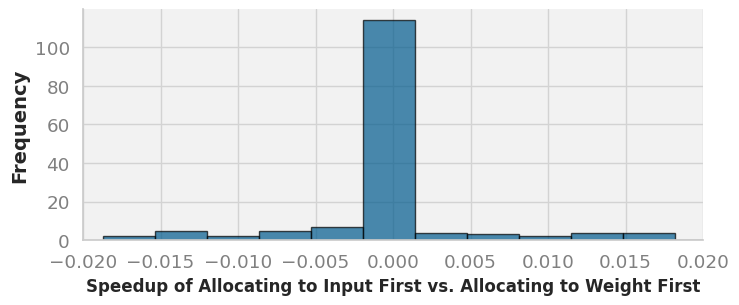

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a formal style using Seaborn
sns.set(style="whitegrid", font_scale=1.2)

# Plot the histogram
plt.figure(figsize=(8, 3))  # Adjust the figure size if needed
plt.hist(df_os_aux["ws_faster_mag"], bins=40, color='#005a8d', edgecolor='black', alpha=0.7)
plt.xlim(-0.02,0.02)

# Add labels and title with formal styling
plt.xlabel("Speedup of Allocating to Input First vs. Allocating to Weight First", fontsize=12, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')
# plt.title("Histogram of ws_faster_mag", fontsize=16, fontweight='bold')

# Customize grid and tick colors
plt.grid(color='lightgray')
plt.tick_params(colors='gray')

# Add a formal background color
plt.gca().set_facecolor('#f2f2f2')

# Remove the top and right spines
sns.despine(top=True, right=True)

# Save the plot as a PNG image
plt.savefig("images/os_anchored_isvsws.png", dpi=300)

# Show the plot
plt.show()

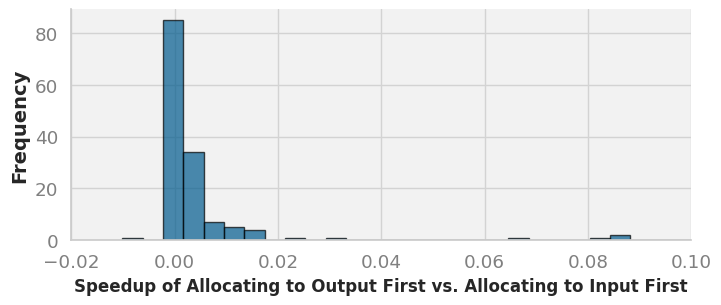

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a formal style using Seaborn
sns.set(style="whitegrid", font_scale=1.2)

# Plot the histogram
plt.figure(figsize=(8, 3))  # Adjust the figure size if needed
plt.hist(df_ws_aux["os_faster_mag"], bins=45, color='#005a8d', edgecolor='black', alpha=0.7)
plt.xlim(-0.02,0.10)

# Add labels and title with formal styling
plt.xlabel("Speedup of Allocating to Output First vs. Allocating to Input First", fontsize=12, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')
# plt.title("Histogram of ws_faster_mag", fontsize=16, fontweight='bold')

# Customize grid and tick colors
plt.grid(color='lightgray')
plt.tick_params(colors='gray')

# Add a formal background color
plt.gca().set_facecolor('#f2f2f2')

# Remove the top and right spines
sns.despine(top=True, right=True)

# Save the plot as a PNG image
plt.savefig("images/ws_anchored_osvsis.png", dpi=300)

# Show the plot
plt.show()

In [ ]:
df_is_aux

,simSeconds_pws,simTicks_x,finalTick_x,simFreq_x,hostSeconds_x,hostTickRate_x,hostMemory_x,simInsts_x,simOps_x,hostInstRate_x,...,aux_os_y,aux_ws_y,aux_is_y,prefer_ws_y,prefer_os_y,ws_faster,os_faster,os_ws_same,ws_faster_mag,speedup
0,0.012405,1.240452e+10,1.240452e+10,1.000000e+12,131.36,94428729.0,680128.0,43345587.0,46019971.0,329965.0,...,13.0,0.0,NaN,False,True,True,False,False,-0.034099,-0.034099
1,0.010869,1.086873e+10,1.086873e+10,1.000000e+12,104.03,104473775.0,680128.0,32273608.0,32542927.0,310224.0,...,20.0,9.0,NaN,False,True,False,True,False,0.096605,0.096605
2,0.019106,1.910557e+10,1.910557e+10,1.000000e+12,172.12,111004495.0,680120.0,50120864.0,51732258.0,291205.0,...,12.0,1.0,NaN,False,True,False,True,False,0.019156,0.019156
3,0.007817,7.816635e+09,7.816635e+09,1.000000e+12,59.12,132219874.0,680116.0,16454028.0,16723782.0,278322.0,...,6.0,9.0,NaN,True,True,False,False,True,0.000000,0.000000
4,0.012109,1.210893e+10,1.210893e+10,1.000000e+12,133.14,90946330.0,680128.0,39841618.0,45676041.0,299237.0,...,5.0,0.0,NaN,False,True,True,False,False,-0.056074,-0.056074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.020468,2.046808e+10,2.046808e+10,1.000000e+12,172.75,118481587.0,680120.0,51110325.0,52731068.0,295857.0,...,12.0,1.0,NaN,False,True,False,True,False,0.026529,0.026529
140,0.010430,1.042950e+10,1.042950e+10,1.000000e+12,82.73,126069197.0,680116.0,20925596.0,21396831.0,252942.0,...,6.0,7.0,NaN,False,True,False,True,False,0.183701,0.183701
141,0.010844,1.084392e+10,1.084392e+10,1.000000e+12,82.52,131407172.0,680124.0,22645621.0,25155839.0,274420.0,...,5.0,0.0,NaN,False,True,True,False,False,-0.001568,-0.001568
142,0.008725,8.724700e+09,8.724700e+09,1.000000e+12,73.27,119083041.0,680116.0,20031257.0,20301402.0,273405.0,...,12.0,16.0,NaN,True,True,False,False,True,0.000000,0.000000


In [ ]:
df_os_aux["ws_faster_mag"]= (df_os_aux["simSeconds_pws"] - df_os_aux["simSeconds_pis"])/df_os_aux["simSeconds_pis"]

In [ ]:
len(df_os_aux[df_os_aux["ws_faster"]]) / len(df_os_aux[df_os_aux["is_faster"]])

0.5238095238095238

In [ ]:
df_os_aux[df_os_aux["ws_faster"]]

,simSeconds_pis,simTicks_x,finalTick_x,simFreq_x,hostSeconds_x,hostTickRate_x,hostMemory_x,simInsts_x,simOps_x,hostInstRate_x,...,cpu_type_y,aux_os_y,aux_ws_y,aux_is_y,prefer_ws_y,prefer_is_y,ws_faster,is_os_same,is_faster,ws_faster_mag
9,0.039345,3.934540e+10,4.033580e+10,1.000000e+12,294.05,133804361.0,680120.0,63169670.0,87067578.0,214825.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.003711
13,0.014533,1.453293e+10,1.552175e+10,1.000000e+12,239.84,60593567.0,680124.0,57952555.0,83319426.0,241627.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.007569
15,0.010513,1.051256e+10,1.150295e+10,1.000000e+12,89.19,117865278.0,680120.0,23938778.0,30115134.0,268397.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.011985
17,0.010235,1.023521e+10,1.122560e+10,1.000000e+12,147.53,69375901.0,680124.0,45941892.0,57800568.0,311401.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.008598
18,0.019704,1.970397e+10,2.069437e+10,1.000000e+12,143.08,137711877.0,680116.0,32413555.0,44497095.0,226540.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.003400
27,0.002469,2.468811e+09,3.459198e+09,1.000000e+12,17.64,139948630.0,680116.0,5497208.0,7215068.0,311616.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.007695
29,0.007216,7.215530e+09,8.204126e+09,1.000000e+12,120.29,59984038.0,680128.0,29804911.0,42622917.0,247773.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.009839
31,0.004462,4.461586e+09,5.450182e+09,1.000000e+12,62.89,70946913.0,680124.0,15731167.0,22274757.0,250152.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.014792
36,0.078597,7.859717e+10,7.958757e+10,1.000000e+12,593.44,132444279.0,680116.0,124681894.0,172208538.0,210102.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.005700
47,0.002855,2.855316e+09,3.843914e+09,1.000000e+12,31.15,91659064.0,680124.0,8694275.0,12100657.0,279094.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.003853


In [ ]:
df_os_aux[df_os_aux["is_faster"]]

,simSeconds_pis,simTicks_x,finalTick_x,simFreq_x,hostSeconds_x,hostTickRate_x,hostMemory_x,simInsts_x,simOps_x,hostInstRate_x,...,cpu_type_y,aux_os_y,aux_ws_y,aux_is_y,prefer_ws_y,prefer_is_y,ws_faster,is_os_same,is_faster,ws_faster_mag
1,0.008628,8.627934e+09,9.617570e+09,1.000000e+12,135.51,63668989.0,680132.0,39784101.0,46761477.0,293582.0,...,ArmO3,NaN,13.0,0.0,True,True,False,False,True,0.041725
2,0.016937,1.693749e+10,1.792713e+10,1.000000e+12,254.88,66451516.0,680132.0,77910753.0,91596337.0,305670.0,...,ArmO3,NaN,13.0,0.0,True,True,False,False,True,0.048651
3,0.134591,1.345911e+11,1.355798e+11,1.000000e+12,1760.62,76445430.0,680140.0,507362255.0,670766370.0,288173.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.056386
12,0.066762,6.676163e+10,6.775011e+10,1.000000e+12,901.30,74072411.0,680136.0,254509783.0,336346409.0,282380.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.053638
24,0.003189,3.189287e+09,4.179620e+09,1.000000e+12,36.72,86856303.0,680124.0,11729190.0,15170364.0,319427.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.006899
35,0.015552,1.555194e+10,1.654228e+10,1.000000e+12,216.39,71871475.0,680124.0,58596770.0,72082190.0,270798.0,...,ArmO3,NaN,13.0,0.0,True,True,False,False,True,0.036844
37,0.014066,1.406616e+10,1.505558e+10,1.000000e+12,192.94,72902712.0,680128.0,45451663.0,66108353.0,235569.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.012228
41,0.050974,5.097350e+10,5.196384e+10,1.000000e+12,617.51,82547369.0,680124.0,165492852.0,218097802.0,268002.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.002943
43,0.027090,2.709045e+10,2.807987e+10,1.000000e+12,368.18,73579300.0,680132.0,89245904.0,130290114.0,242397.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.011554
48,0.016720,1.671994e+10,1.770842e+10,1.000000e+12,227.14,73609909.0,680136.0,64870522.0,85531556.0,285594.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.053170


<Axes: >

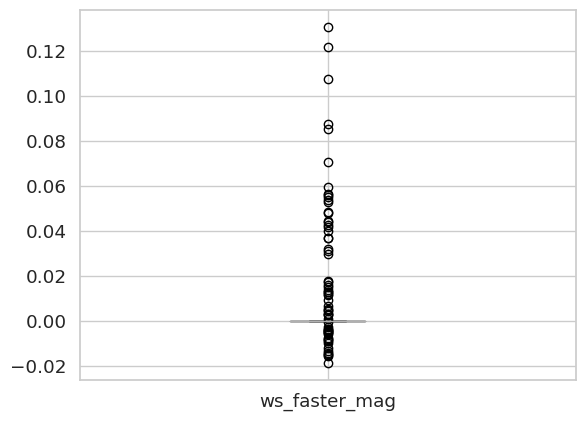

In [ ]:
df_os_aux.boxplot(column="ws_faster_mag")

<Axes: xlabel='simSeconds_pis'>

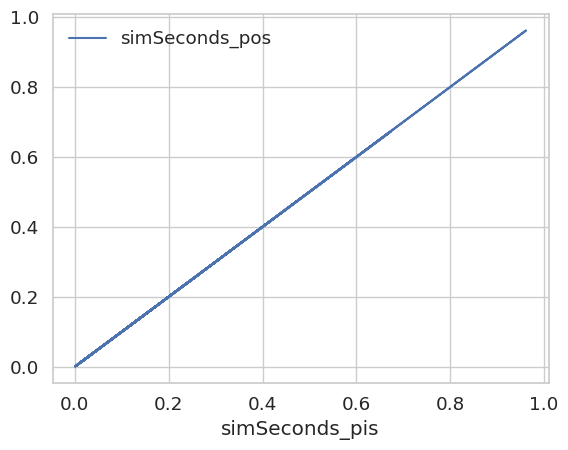

In [ ]:
df_ws_aux.plot(x="simSeconds_pis",y="simSeconds_pos")

In [ ]:
df_is_os_opt = pd.merge(df_is_aux,df_os_aux,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

In [ ]:
df_is_os_opt

,simSeconds_pws_x,simTicks_x_x,finalTick_x_x,simFreq_x_x,hostSeconds_x_x,hostTickRate_x_x,hostMemory_x_x,simInsts_x_x,simOps_x_x,hostInstRate_x_x,...,cpu_type_y_y,aux_os_y_y,aux_ws_y_y,aux_is_y_y,prefer_ws_y_y,prefer_is_y,ws_faster_y,is_os_same,is_faster,ws_faster_mag_y
0,0.012405,1.240452e+10,1.240452e+10,1.000000e+12,131.36,94428729.0,680128.0,43345587.0,46019971.0,329965.0,...,ArmO3,NaN,13.0,0.0,True,True,False,True,False,0.000000
1,0.012405,1.240452e+10,1.240452e+10,1.000000e+12,131.36,94428729.0,680128.0,43345587.0,46019971.0,329965.0,...,ArmO3,NaN,13.0,0.0,True,True,False,False,True,0.037014
2,0.010869,1.086873e+10,1.086873e+10,1.000000e+12,104.03,104473775.0,680128.0,32273608.0,32542927.0,310224.0,...,ArmO3,NaN,25.0,4.0,True,True,False,True,False,0.000000
3,0.019106,1.910557e+10,1.910557e+10,1.000000e+12,172.12,111004495.0,680120.0,50120864.0,51732258.0,291205.0,...,ArmO3,NaN,13.0,0.0,True,True,False,True,False,0.000000
4,0.007817,7.816635e+09,7.816635e+09,1.000000e+12,59.12,132219874.0,680116.0,16454028.0,16723782.0,278322.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.010844,1.084392e+10,1.084392e+10,1.000000e+12,82.52,131407172.0,680124.0,22645621.0,25155839.0,274420.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.000201
204,0.010844,1.084392e+10,1.084392e+10,1.000000e+12,82.52,131407172.0,680124.0,22645621.0,25155839.0,274420.0,...,ArmO3,NaN,5.0,0.0,True,True,False,True,False,0.000000
205,0.008725,8.724700e+09,8.724700e+09,1.000000e+12,73.27,119083041.0,680116.0,20031257.0,20301402.0,273405.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,0.057583,5.758263e+10,5.758263e+10,1.000000e+12,825.95,69717056.0,680136.0,252226153.0,291901088.0,305378.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.017632


In [ ]:
df_is_os_opt["os_speedup"] =  df_is_os_opt["simSeconds_pos"] / df_is_os_opt["simSeconds_pws_y"]

In [ ]:
len(df_is_os_opt[df_is_os_opt["os_speedup"]>=1])/len(df_is_os_opt)

0.7932692307692307

<Axes: >

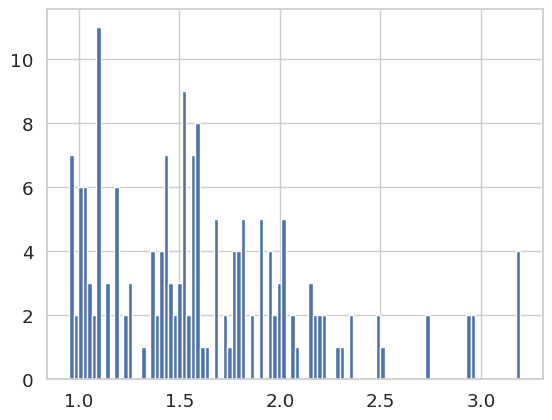

In [ ]:
df_is_os_opt["os_speedup"].hist(bins = 100)

In [ ]:
df_opt_bl = pd.merge(df_is_os_opt,df_bl_tp,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

In [ ]:
df_opt_bl

,simSeconds_pws_x,simTicks_x_x,finalTick_x_x,simFreq_x_x,hostSeconds_x_x,hostTickRate_x_x,hostMemory_x_x,simInsts_x_x,simOps_x_x,hostInstRate_x_x,...,simInsts_os,simOps_os,anchoring_stationary_y,simSeconds_ws,simInsts_ws,simOps_ws,anchoring_stationary,is_over_os,ws_over_os,ws_over_is
0,0.012405,1.240452e+10,1.240452e+10,1.000000e+12,131.36,94428729.0,680128.0,43345587.0,46019971.0,329965.0,...,65148402.0,75099496.0,os,0.087809,61857544.0,66969039.0,ws,1.661908,6.849910,4.121714
1,0.012405,1.240452e+10,1.240452e+10,1.000000e+12,131.36,94428729.0,680128.0,43345587.0,46019971.0,329965.0,...,65148402.0,75099496.0,os,0.087809,61857544.0,66969039.0,ws,1.661908,6.849910,4.121714
2,0.010869,1.086873e+10,1.086873e+10,1.000000e+12,104.03,104473775.0,680128.0,32273608.0,32542927.0,310224.0,...,60315625.0,60587290.0,os,0.076688,57063262.0,57334839.0,ws,2.009631,7.385919,3.675261
3,0.019106,1.910557e+10,1.910557e+10,1.000000e+12,172.12,111004495.0,680120.0,50120864.0,51732258.0,291205.0,...,86625005.0,99062272.0,os,0.084596,78960163.0,85316407.0,ws,2.282176,6.038689,2.646023
4,0.007817,7.816635e+09,7.816635e+09,1.000000e+12,59.12,132219874.0,680116.0,16454028.0,16723782.0,278322.0,...,49501258.0,49773008.0,os,0.046242,41875031.0,42146637.0,ws,2.957720,5.446002,1.841284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.010844,1.084392e+10,1.084392e+10,1.000000e+12,82.52,131407172.0,680124.0,22645621.0,25155839.0,274420.0,...,34288229.0,43430443.0,os,0.033400,30507779.0,35214794.0,ws,1.105103,2.744679,2.483641
204,0.010844,1.084392e+10,1.084392e+10,1.000000e+12,82.52,131407172.0,680124.0,22645621.0,25155839.0,274420.0,...,34288229.0,43430443.0,os,0.033400,30507779.0,35214794.0,ws,1.105103,2.744679,2.483641
205,0.008725,8.724700e+09,8.724700e+09,1.000000e+12,73.27,119083041.0,680116.0,20031257.0,20301402.0,273405.0,...,74458846.0,74729969.0,os,0.080243,66902548.0,67173674.0,ws,2.659567,7.004452,2.633681
206,0.057583,5.758263e+10,5.758263e+10,1.000000e+12,825.95,69717056.0,680136.0,252226153.0,291901088.0,305378.0,...,333052259.0,430123353.0,os,0.355337,319869459.0,368544554.0,ws,1.111415,4.540642,4.085460


In [ ]:
df_bl_tp

,simSeconds_is,simInsts_is,simOps_is,vector_length,num_bits,stride,filter_size,anchoring_stationary_x,input_hw,num_filters,...,simInsts_os,simOps_os,anchoring_stationary_y,simSeconds_ws,simInsts_ws,simOps_ws,anchoring_stationary,is_over_os,ws_over_os,ws_over_is
0,0.021003,33753483.0,34269763.0,256,8,2,5,is,56,32,...,17734332.0,20372914.0,os,0.006335,17080178.0,18536617.0,ws,5.652045,1.704790,0.301624
1,0.008192,15191466.0,15680024.0,256,1,2,3,is,56,32,...,8803833.0,9957343.0,os,0.004044,7907847.0,8620925.0,ws,3.292605,1.625402,0.493652
2,0.004804,13702812.0,14784495.0,256,1,1,4,is,56,8,...,13433136.0,15225598.0,os,0.011012,12472358.0,13504604.0,ws,1.443510,3.308894,2.292256
3,0.025354,59709872.0,63867203.0,256,1,1,3,is,56,64,...,58213276.0,65454626.0,os,0.048583,50525610.0,54283168.0,ws,2.479366,4.750929,1.916187
4,0.064387,197878337.0,211455543.0,256,1,1,4,is,112,32,...,189695501.0,214973782.0,os,0.222222,174777531.0,187553428.0,ws,1.696985,5.856887,3.451349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.002820,5045534.0,5371609.0,256,8,2,3,is,56,8,...,3284963.0,3776576.0,os,0.001410,3062121.0,3443655.0,ws,2.203125,1.101562,0.500000
284,0.022904,51120183.0,51391760.0,128,1,1,3,is,112,16,...,49167118.0,49438791.0,os,0.053352,41638683.0,41910260.0,ws,2.313535,5.389091,2.329375
285,0.188082,310741427.0,311012522.0,128,8,1,5,is,112,64,...,432072062.0,432343156.0,os,0.510858,406092468.0,406363565.0,ws,3.104637,8.432644,2.716145
286,0.032718,99773118.0,106697268.0,256,1,1,4,is,112,16,...,95683002.0,108457971.0,os,0.111791,88223768.0,94747505.0,ws,1.673897,5.719380,3.416804


In [ ]:
df_opt_bl["speedup over baseline os"] = df_opt_bl["simSeconds_os"] / df_opt_bl["simSeconds_pws_y"]
df_opt_bl["speedup over baseline ws"] = df_opt_bl["simSeconds_ws"] / df_opt_bl["simSeconds_pws_y"] 
df_opt_bl["speedup over baseline is"] = df_opt_bl["simSeconds_is"] / df_opt_bl["simSeconds_pws_y"]

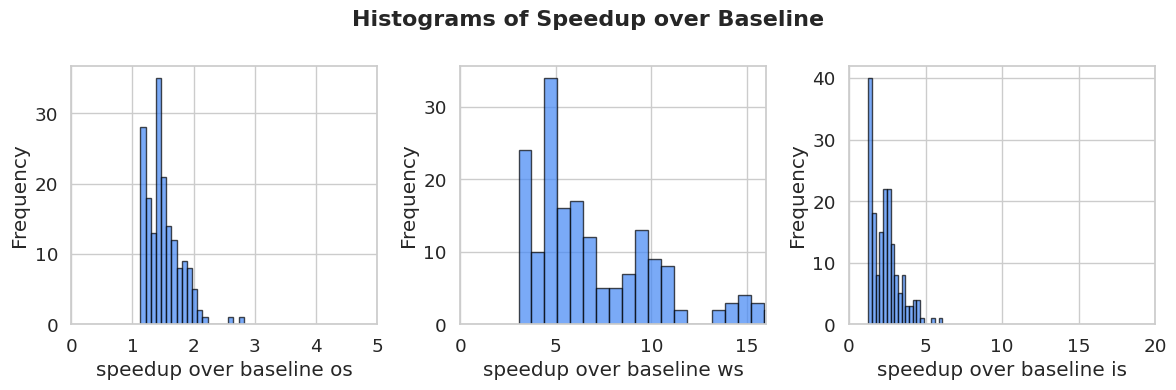

In [ ]:
import matplotlib.pyplot as plt

# Define the columns for which you want to plot histograms
columns = ["speedup over baseline os", "speedup over baseline ws", "speedup over baseline is"]

# Define custom bins and x-axis limits for each column
bin_values = [20, 20, 20]
xlim_values = [(0, 5), (0, 16), (0, 20)]

# Create subplots for each column
fig, axes = plt.subplots(1, len(columns), figsize=(12, 4))

# Plot histograms for each column
for i, col in enumerate(columns):
    axes[i].hist(df_opt_bl[col], bins=bin_values[i], color='#4287f5', edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    axes[i].set_xlim(xlim_values[i])

# Set title for the overall plot
fig.suptitle("Histograms of Speedup over Baseline", fontsize=16, fontweight='bold')

# Adjust spacing between subplots
plt.tight_layout()



# Show the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'Layer': ['VGG Conv2_2', 'VGG Conv3_2', 'VGG Conv4_2', 'VGG Conv2_2', 'VGG Conv3_2', 'VGG Conv4_2'],
    'Type': ['binary']*3 + ['8bit']*3,
    'Ours': [4.782377087, 4.178856215, 2.3222179, 1.785197951, 1.845317089, 3.686647173],
    'Baseline OS': [1.789148239, 1.473581154, 1.36142829, 1.037413352, 1.160369439, 2.452036129],
    'Liu et al.': [1, 1, 1, 1, 1, 1]
}

df = pd.DataFrame(data)

sns.set(style='whitegrid', palette='muted', font_scale=1.2, rc={"figure.figsize": [6, 4]})

# Function to create bar plot
def create_plot(df, title, filename):
    ax = df.plot(kind='bar', width=0.8)  # Increase bar width to 0.8
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Speedup', fontsize=12, fontweight='bold')
    plt.xlabel('Layer', fontsize=12, fontweight='bold')
    plt.xticks(rotation=0, fontsize='medium', fontweight='bold')
    plt.yticks(fontsize='medium')
    ax.legend(fontsize='medium')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(filename)
    plt.clf()

# Binary plot
df_binary = df[df['Type'] == 'binary']
df_binary.set_index('Layer')[['Ours', 'Baseline OS', 'Liu et al.']].pipe(
    create_plot,
    title='Binary Speedups',
    filename='images/binary_speedups_real.png'
)

# 8bit plot
df_8bit = df[df['Type'] == '8bit']
df_8bit.set_index('Layer')[['Ours', 'Baseline OS', 'Liu et al.']].pipe(
    create_plot,
    title='8bit Speedups',
    filename='images/8bit_speedups_real.png'
)


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

/tmp/ipykernel_267266/3005337084.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


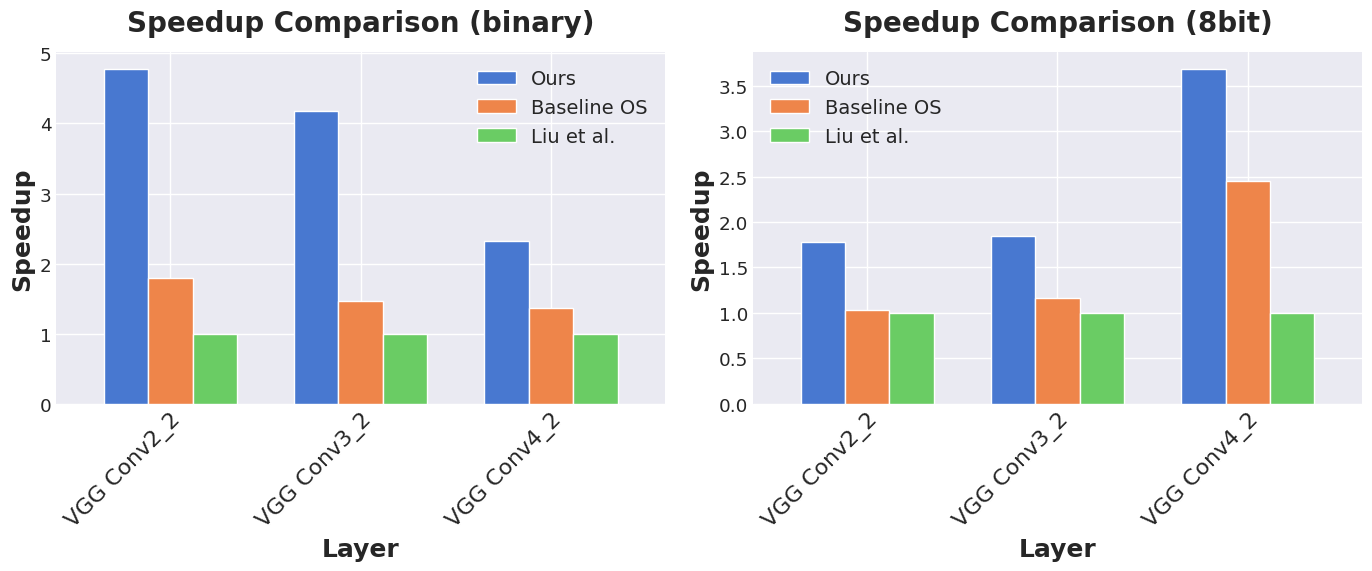

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'Layer': ['VGG Conv2_2', 'VGG Conv3_2', 'VGG Conv4_2', 'VGG Conv2_2', 'VGG Conv3_2', 'VGG Conv4_2'],
    'Type': ['binary']*3 + ['8bit']*3,
    'Ours': [4.782377087, 4.178856215, 2.3222179, 1.785197951, 1.845317089, 3.686647173],
    'Baseline OS': [1.789148239, 1.473581154, 1.36142829, 1.037413352, 1.160369439, 2.452036129],
    'Liu et al.': [1, 1, 1, 1, 1, 1]
}

df = pd.DataFrame(data)

# Set a plotting style to make it look more academic
plt.style.use('seaborn-darkgrid')

# Increase the font size
plt.rcParams.update({'font.size': 16})

# Set the color palette to "muted"
sns.set_palette("muted")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create a figure with two subplots arranged in a 1x2 grid
axes = axes.flatten()  # Flatten the axes array for easier indexing

types = ['binary', '8bit']

for i, type in enumerate(types):
    df_subset = df[df["Type"] == type]  # Subset the data based on type
    
    ax = axes[i]  # Select the current subplot
    df_subset.set_index('Layer')[['Ours', 'Baseline OS', 'Liu et al.']].plot(kind='bar', ax=ax, width=0.7)
    ax.set_xlabel('Layer', fontsize=18, fontweight='bold')
    ax.set_ylabel('Speedup', fontsize=18, fontweight='bold')
    ax.set_title(f'Speedup Comparison ({type})', fontsize=20, pad=15, fontweight='bold')
    ax.legend(fontsize='14', title_fontsize='14')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=16)  # Rotate x-tick labels and increase font size

plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust spacing between subplots
plt.savefig("images/speedups_comparison.png", dpi=300, bbox_inches='tight')  # Save the figure
plt.show()


/tmp/ipykernel_267266/1965441436.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


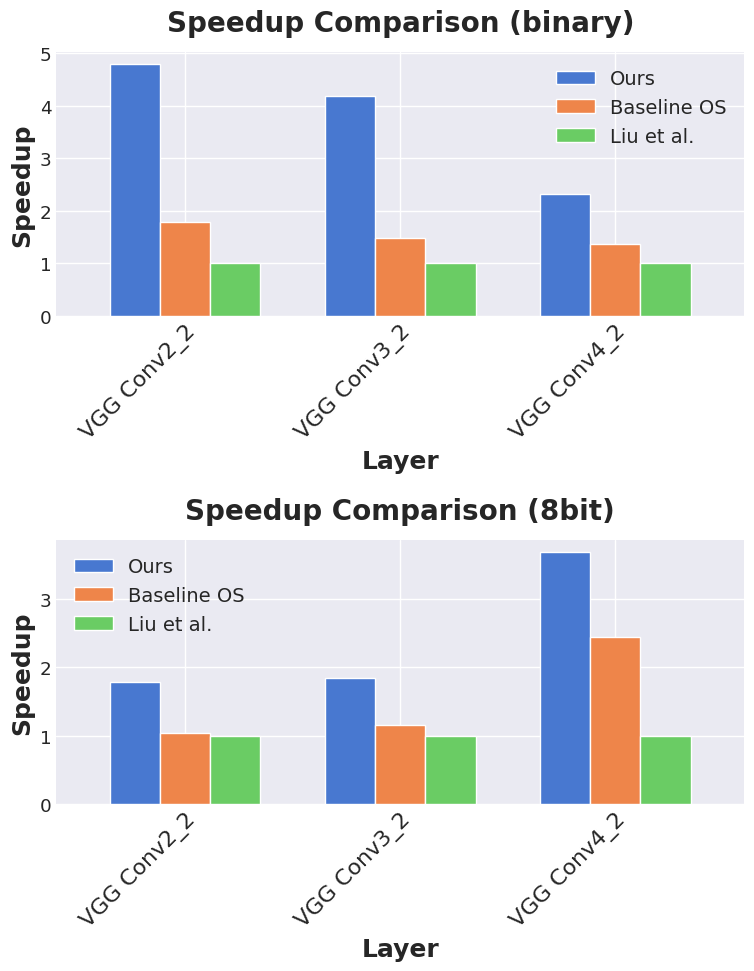

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'Layer': ['VGG Conv2_2', 'VGG Conv3_2', 'VGG Conv4_2', 'VGG Conv2_2', 'VGG Conv3_2', 'VGG Conv4_2'],
    'Type': ['binary']*3 + ['8bit']*3,
    'Ours': [4.782377087, 4.178856215, 2.3222179, 1.785197951, 1.845317089, 3.686647173],
    'Baseline OS': [1.789148239, 1.473581154, 1.36142829, 1.037413352, 1.160369439, 2.452036129],
    'Liu et al.': [1, 1, 1, 1, 1, 1]
}

df = pd.DataFrame(data)

# Set a plotting style to make it look more academic
plt.style.use('seaborn-darkgrid')

# Increase the font size
plt.rcParams.update({'font.size': 16})

# Set the color palette to "muted"
sns.set_palette("muted")

fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # Create a figure with two subplots arranged in a 2x1 grid
axes = axes.flatten()  # Flatten the axes array for easier indexing

types = ['binary', '8bit']

for i, type in enumerate(types):
    df_subset = df[df["Type"] == type]  # Subset the data based on type
    
    ax = axes[i]  # Select the current subplot
    df_subset.set_index('Layer')[['Ours', 'Baseline OS', 'Liu et al.']].plot(kind='bar', ax=ax, width=0.7)
    ax.set_xlabel('Layer', fontsize=18, fontweight='bold')
    ax.set_ylabel('Speedup', fontsize=18, fontweight='bold')
    ax.set_title(f'Speedup Comparison ({type})', fontsize=20, pad=15, fontweight='bold')
    ax.legend(fontsize='14', title_fontsize='14')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=16)  # Rotate x-tick labels and increase font size

plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust spacing between subplots
plt.savefig("images/speedups_comparison.png", dpi=300, bbox_inches='tight')  # Save the figure
plt.show()


/tmp/ipykernel_267607/2359501583.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
/tmp/ipykernel_267607/2359501583.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=20,fontweight='bold')
/tmp/ipykernel_267607/2359501583.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=20,fontweight='bold')


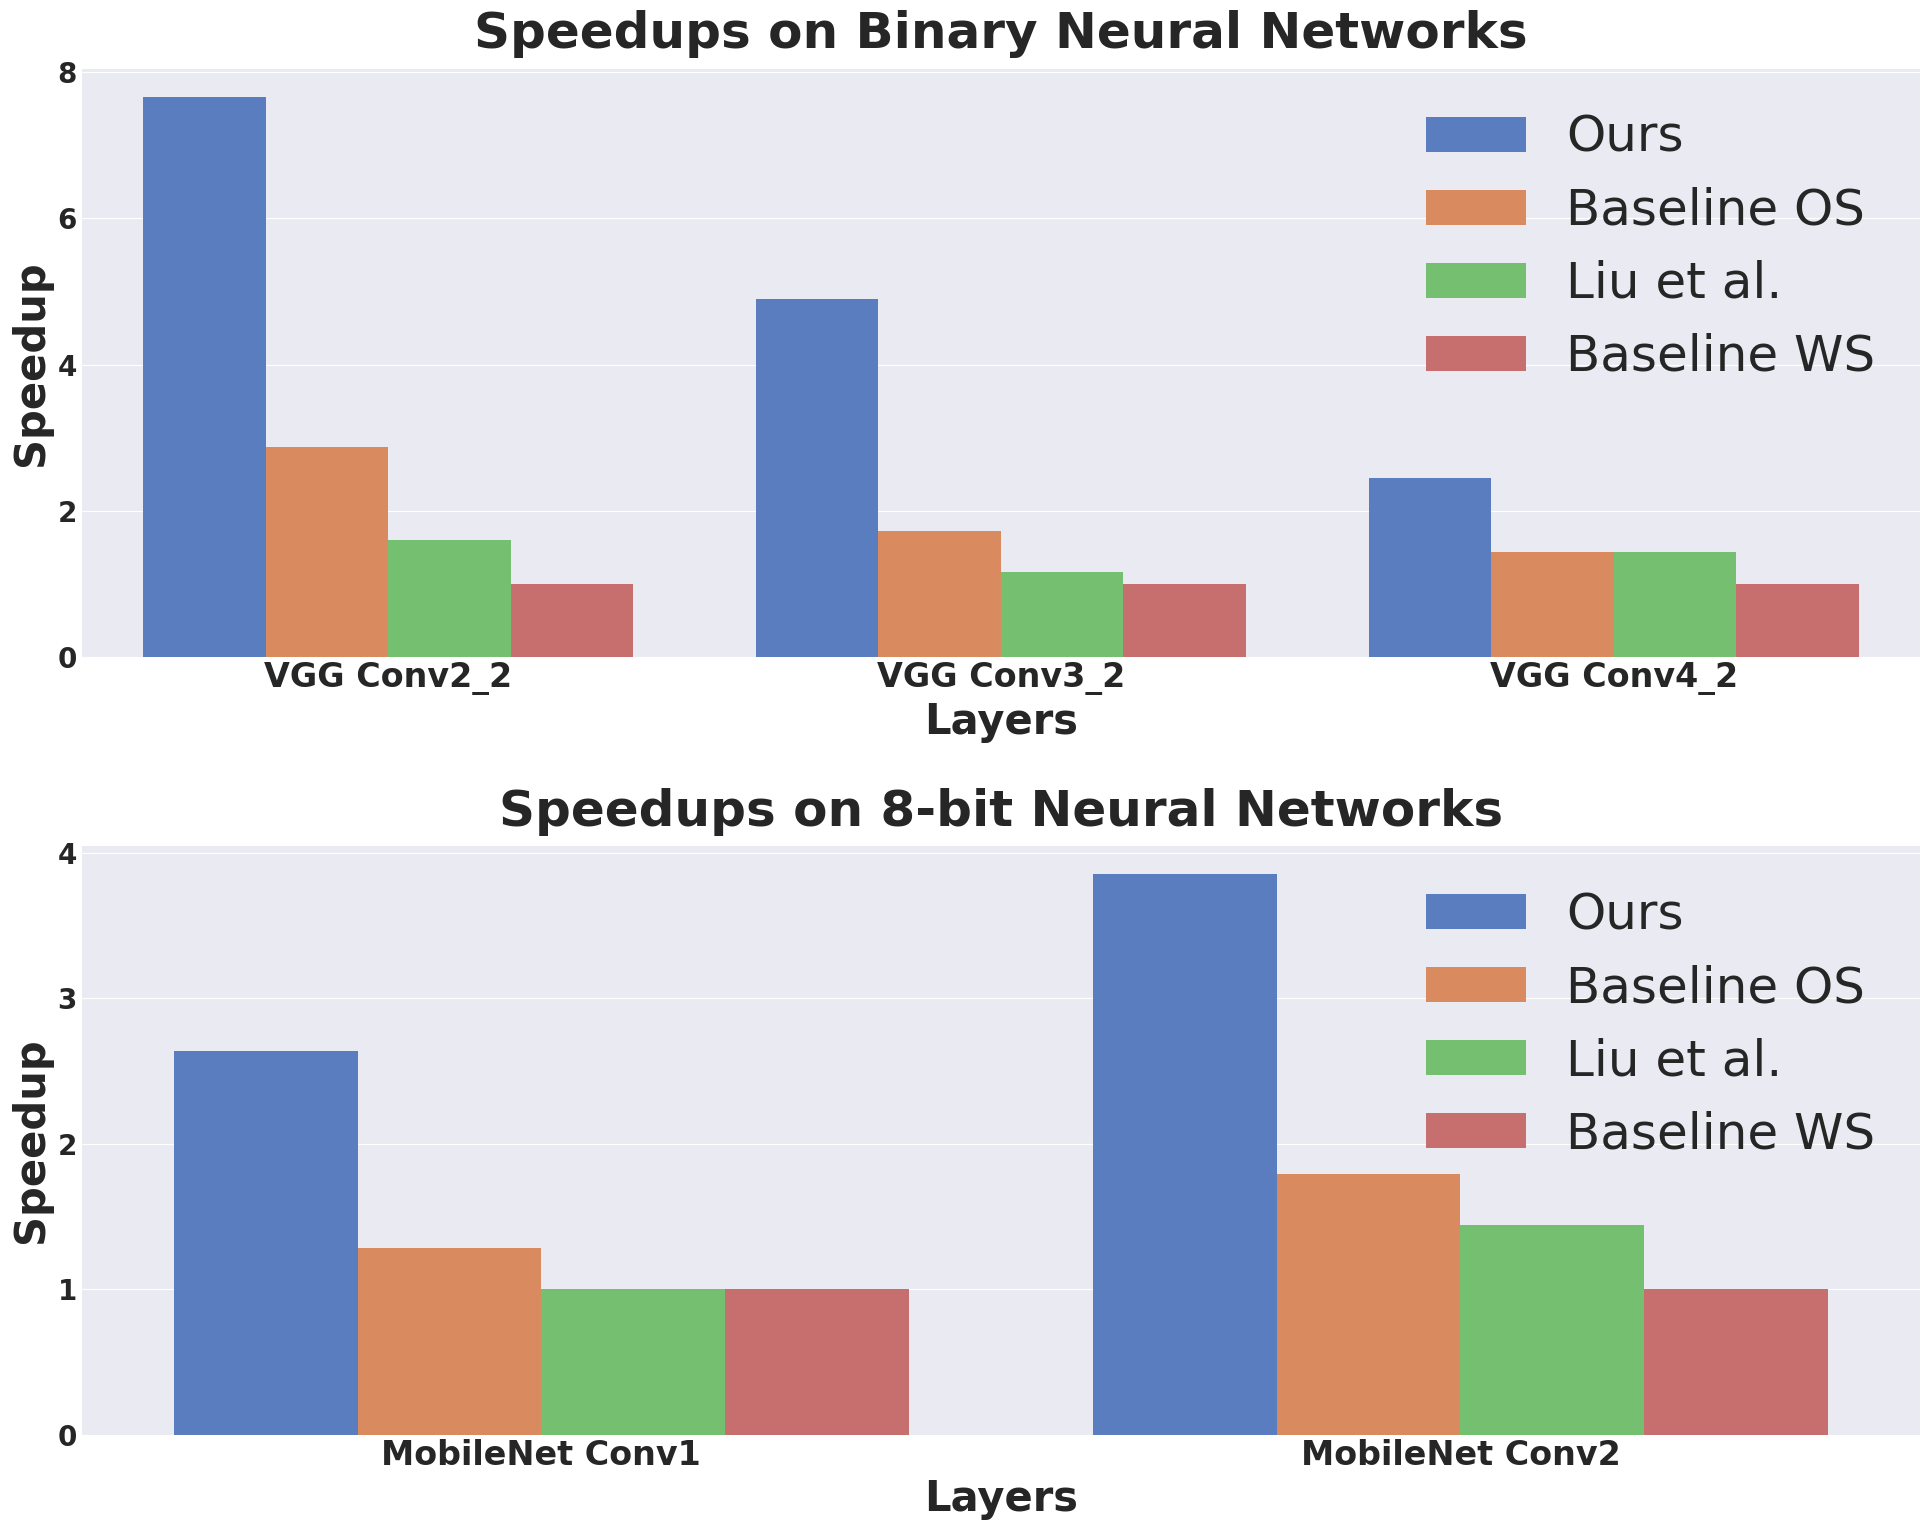

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set a plotting style to make it look more academic
plt.style.use('seaborn-darkgrid')

# Increase the font size
plt.rcParams.update({'font.size': 30})

# Set the color palette to "muted"
sns.set_palette("muted")

# Data for the first graph
data1 = {
    'Layer': ['VGG Conv2_2', 'VGG Conv2_2', 'VGG Conv2_2', 'VGG Conv2_2', 'VGG Conv3_2', 'VGG Conv3_2', 'VGG Conv3_2', 'VGG Conv3_2', 'VGG Conv4_2', 'VGG Conv4_2', 'VGG Conv4_2', 'VGG Conv4_2'],
    'Method': ['Ours', 'Baseline OS', 'Liu et al.', 'Baseline WS', 'Ours', 'Baseline OS', 'Liu et al.', 'Baseline WS', 'Ours', 'Baseline OS', 'Liu et al.', 'Baseline WS'],
    'Speedup': [7.664179513, 2.867267267, 1.602587871, 1, 4.892570402, 1.725256665, 1.170791755, 1, 2.456664309, 1.440249121, 1.440249121, 1]
}

df1 = pd.DataFrame(data1)

# Data for the second graph
data2 = {
    'Layer': ['MobileNet Conv1', 'MobileNet Conv1', 'MobileNet Conv1', 'MobileNet Conv1', 'MobileNet Conv2', 'MobileNet Conv2', 'MobileNet Conv2', 'MobileNet Conv2'],
    'Method': ['Ours', 'Baseline OS', 'Liu et al.', 'Baseline WS', 'Ours', 'Baseline OS', 'Liu et al.', 'Baseline WS'],
    'Speedup': [2.638421271, 1.282366495, 1.002797325, 1, 3.852095933, 1.791444469, 1.443451015, 1]
}

df2 = pd.DataFrame(data2)

# Create a figure with two subplots arranged in a 2x1 grid
fig, axes = plt.subplots(2, 1, figsize=(20, 16))  
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Function to plot a graph
def plot_graph(df, title, ax):
    sns.barplot(data=df, x='Layer', y='Speedup', hue='Method', ax=ax)
    ax.set_xlabel('Layers', fontsize=30, fontweight='bold')
    ax.set_ylabel('Speedup', fontsize=30, fontweight='bold')
    ax.set_title(title, fontsize=36, pad=15, fontweight='bold')
    ax.legend(fontsize='36')  # Increase legend fontsize
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=24,fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20,fontweight='bold')

# Create the graphs
plot_graph(df1, 'Speedups on Binary Neural Networks', axes[0])
plot_graph(df2, 'Speedups on 8-bit Neural Networks', axes[1])

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig("images/speedups.png", dpi=300, bbox_inches='tight')  # Save the figure with the legend included
plt.show()
